In [1]:
!pip install -q ucimlrepo imbalanced-learn xgboost lightgbm

In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, r2_score,
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    f1_score, precision_score, recall_score
)

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
np.random.seed(42)

print("Libraries imported successfully.")


Libraries imported successfully.


In [3]:
# DATA LOADING VIA UCI REPOSITORY (COMMON FOR REGRESSION + CLASSIFICATION)

try:
    concrete = fetch_ucirepo(id=165)  # UCI Concrete Compressive Strength dataset

    X_raw = pd.DataFrame(concrete.data.features, columns=concrete.data.feature_names)
    y_raw = pd.DataFrame(concrete.data.targets, columns=concrete.data.target_names)

    # Concatenate features + target
    df = pd.concat([X_raw, y_raw], axis=1)

    df.columns = [
        "Cement",
        "Blast Furnace Slag",
        "Fly Ash",
        "Water",
        "Superplasticizer",
        "Coarse Aggregate",
        "Fine Aggregate",
        "Age",
        "Strength"
    ]

    print("Dataset loaded from UCI via ucimlrepo.")
    print(f"Shape of the DataFrame: {df.shape}")

except Exception as e:
    print(f"Error loading UCI dataset: {e}")
    df = pd.DataFrame()
print(f"Shape of the DataFrame: {df.shape}")
df.info()
print("\nDescriptive Statistics:")
display(df.describe())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())

Dataset loaded from UCI via ucimlrepo.
Shape of the DataFrame: (1030, 9)
Shape of the DataFrame: (1030, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB

Descriptive Statistics:


Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.000000   
mean    281.167864           73.895825    54.188350   181.567282   
std     104.506364           86.279342    63.997004    21.354219   
min     102.000000            0.000000     0.000000   121.800000   
25%     192.375000            0.000000     0.000000   164.900000   
50%     272.900000           22.000000     0.000000   185.000000   
75%     350.000000          142.950000   118.300000   192.000000   
max     540.000000          359.400000   200.100000   247.000000   

       Superplasticizer  Coarse Aggregate  Fine Aggregate          Age  \
count       1030.000000       1030.000000     1030.000000  1030.000000   
mean           6.204660        972.918932      773.580485    45.662136   
std            5.973841         77.753954       80.175980    63.169912   
min            0.000000        801.000000      594.000000     1.000000   
25%            0.000000        932.000000      730.950000     7.000000   
50%            6.400000        968.000000      779.500000    28.000000   
75%           10.200000       1029.400000      824.000000    56.000000   
max           32.200000       1145.000000      992.600000   365.000000   

          Strength  
count  1030.000000  
mean     35.817961  
std      16.705742  
min       2.330000  
25%      23.710000  
50%      34.445000  
75%      46.135000  
max      82.600000


Missing values per column:
Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

Number of duplicate rows: 25


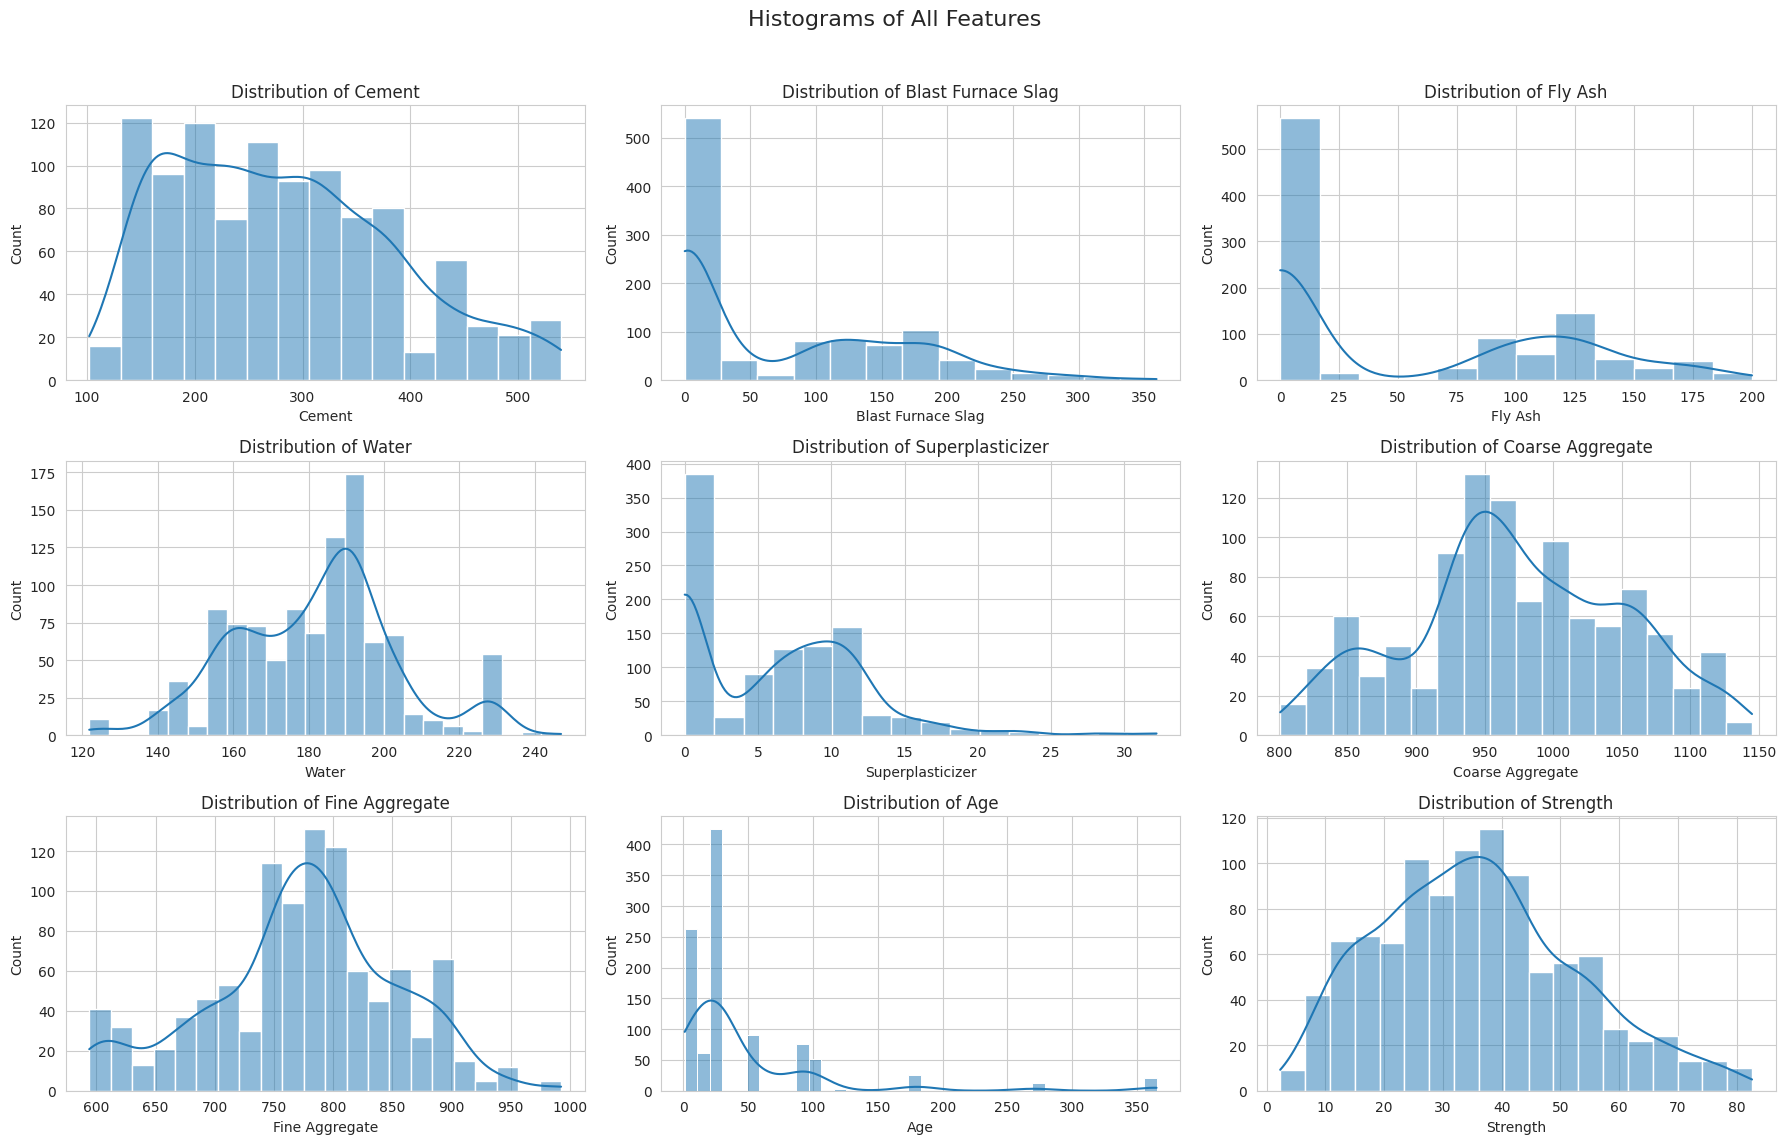

In [4]:
#  EDA (REGRESSION)

num_columns = df.shape[1]
num_rows = (num_columns + 2) // 3  # 3 columns per row

# Histograms
plt.figure(figsize=(18, num_rows * 4))
plt.suptitle('Histograms of All Features', fontsize=16)
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, 3, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

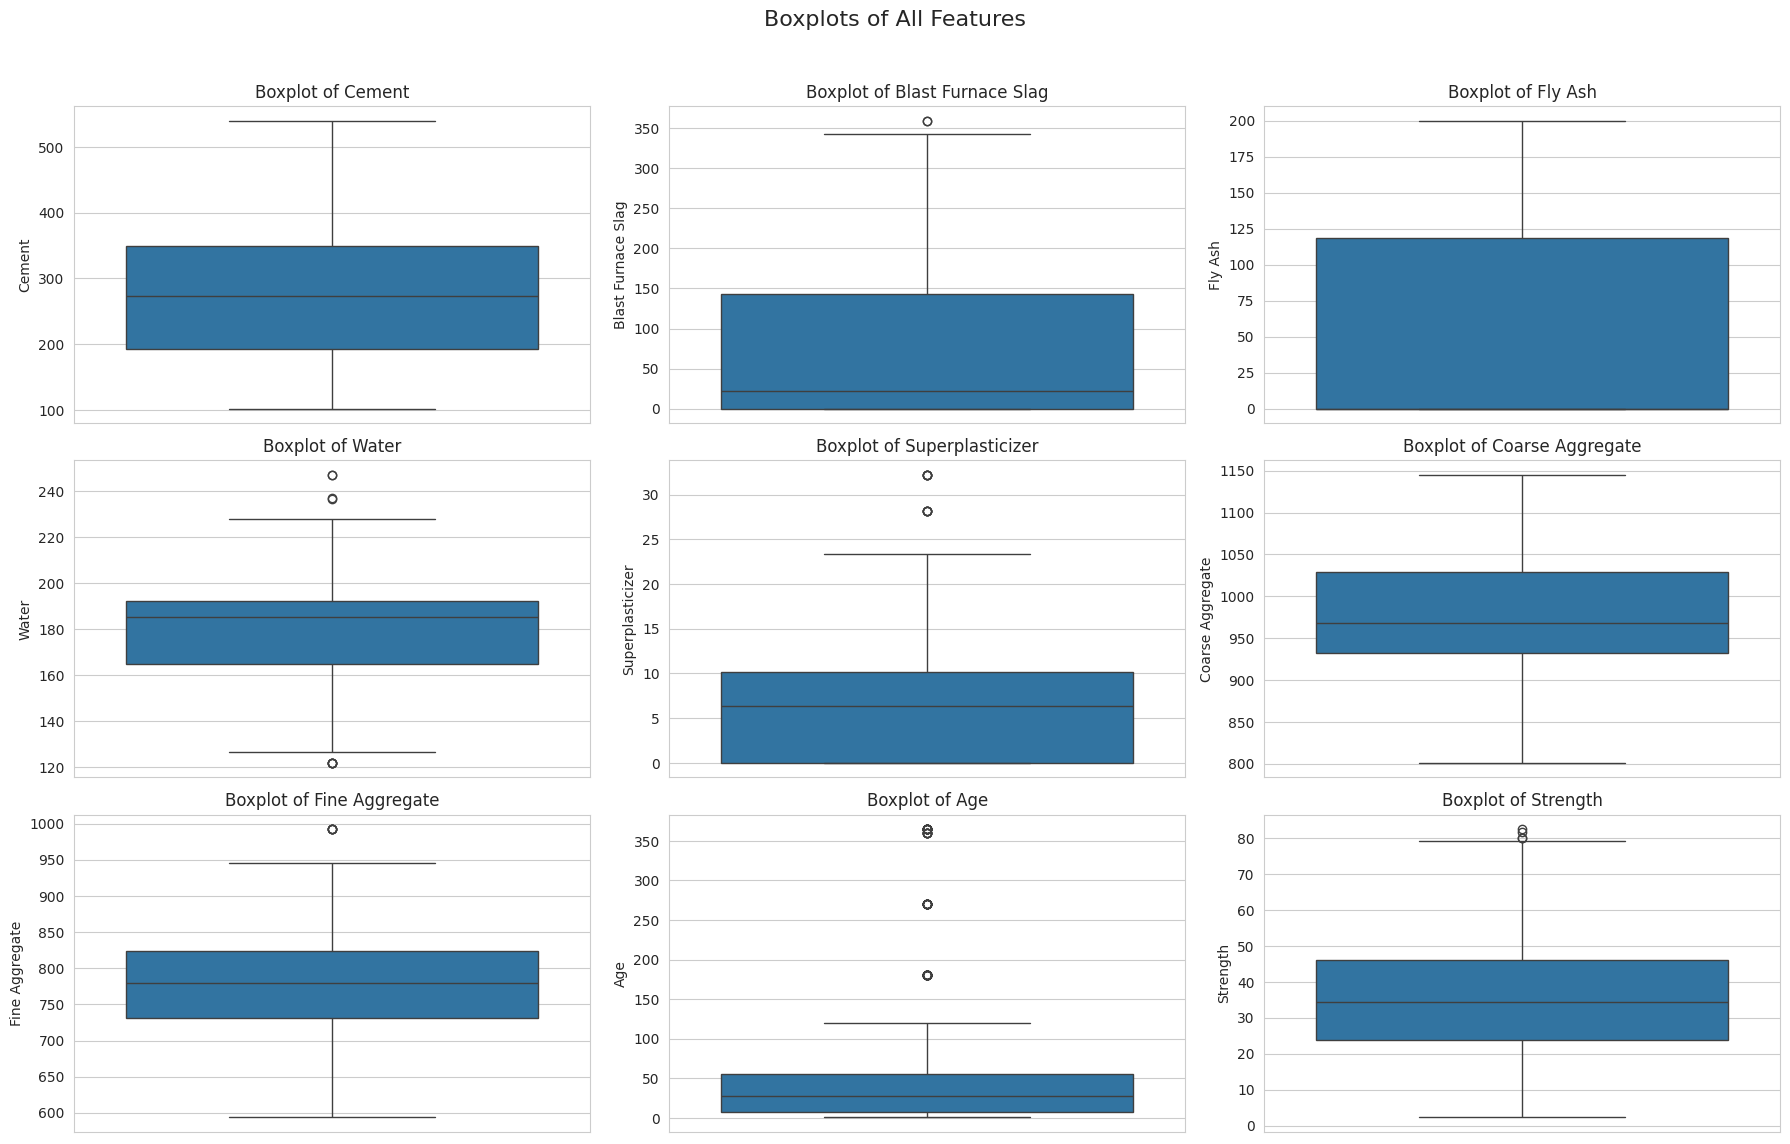

In [5]:
# Boxplots
plt.figure(figsize=(18, num_rows * 4))
plt.suptitle('Boxplots of All Features', fontsize=16)
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, 3, i + 1)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

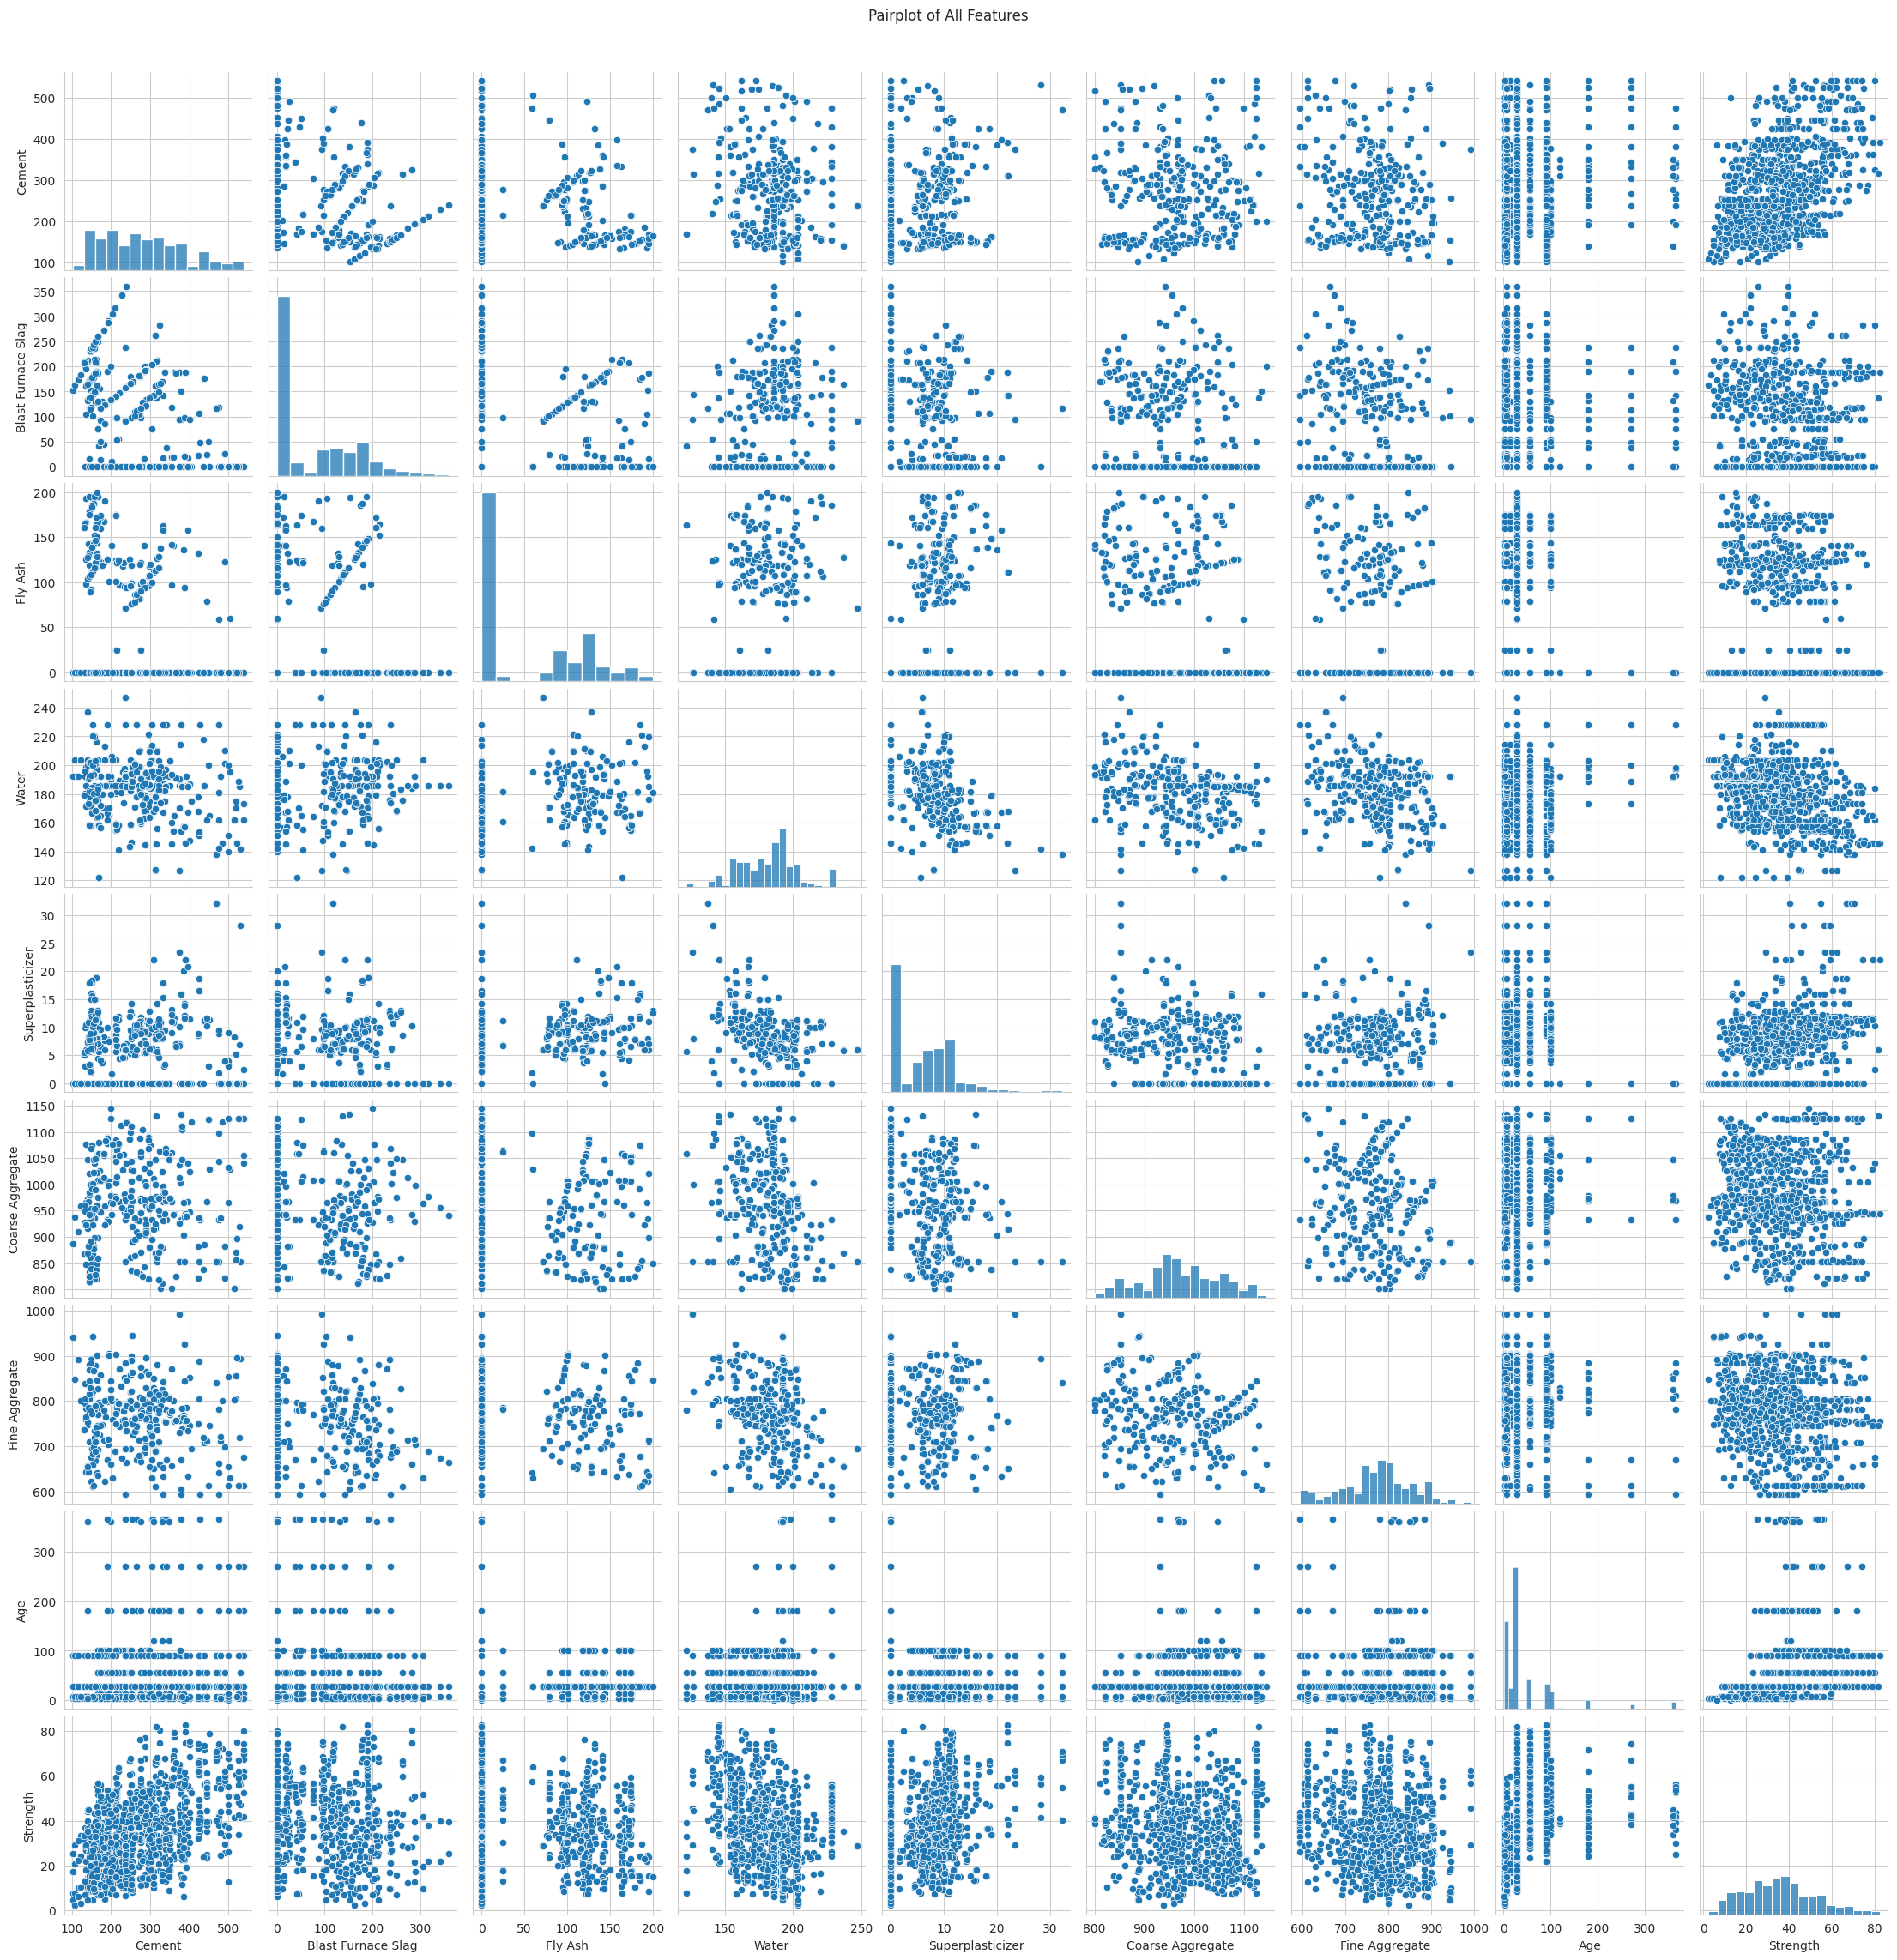

In [6]:
# Pairplot
sns.pairplot(df)
plt.suptitle('Pairplot of All Features', y=1.02)
plt.show()

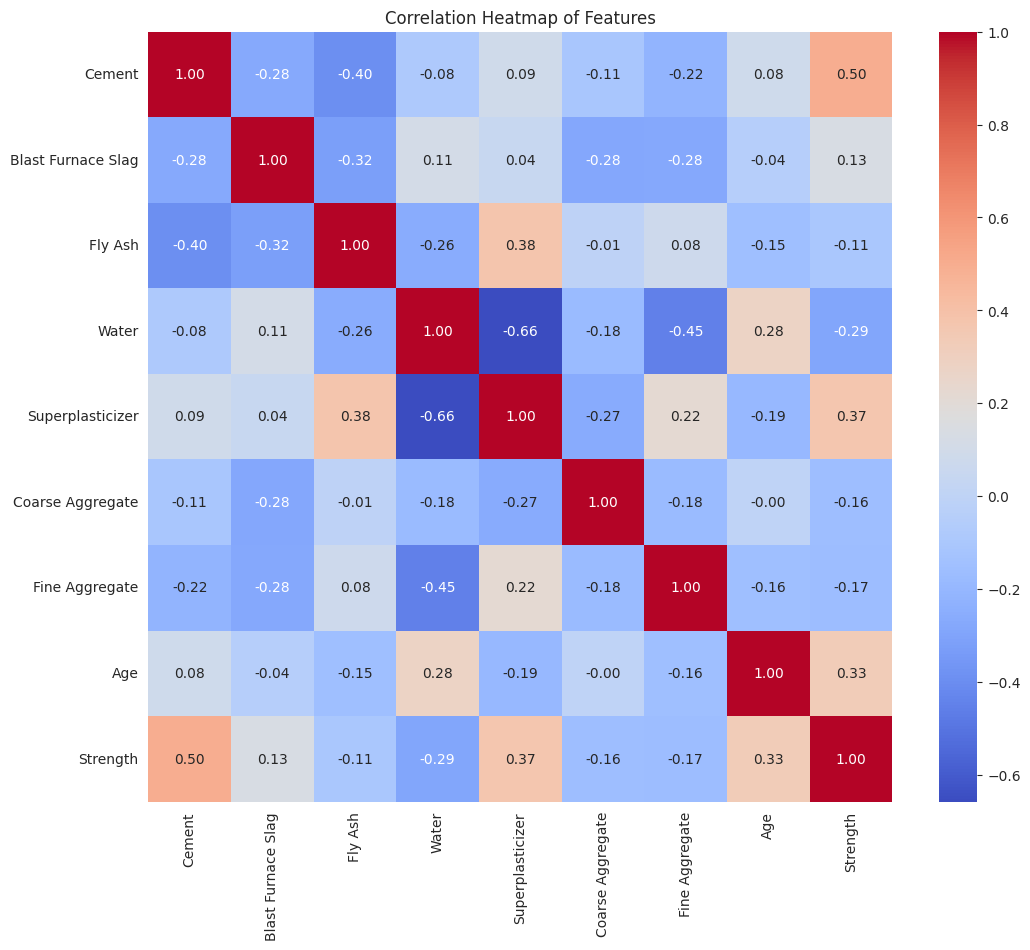

In [7]:
# Correlation heatmap
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

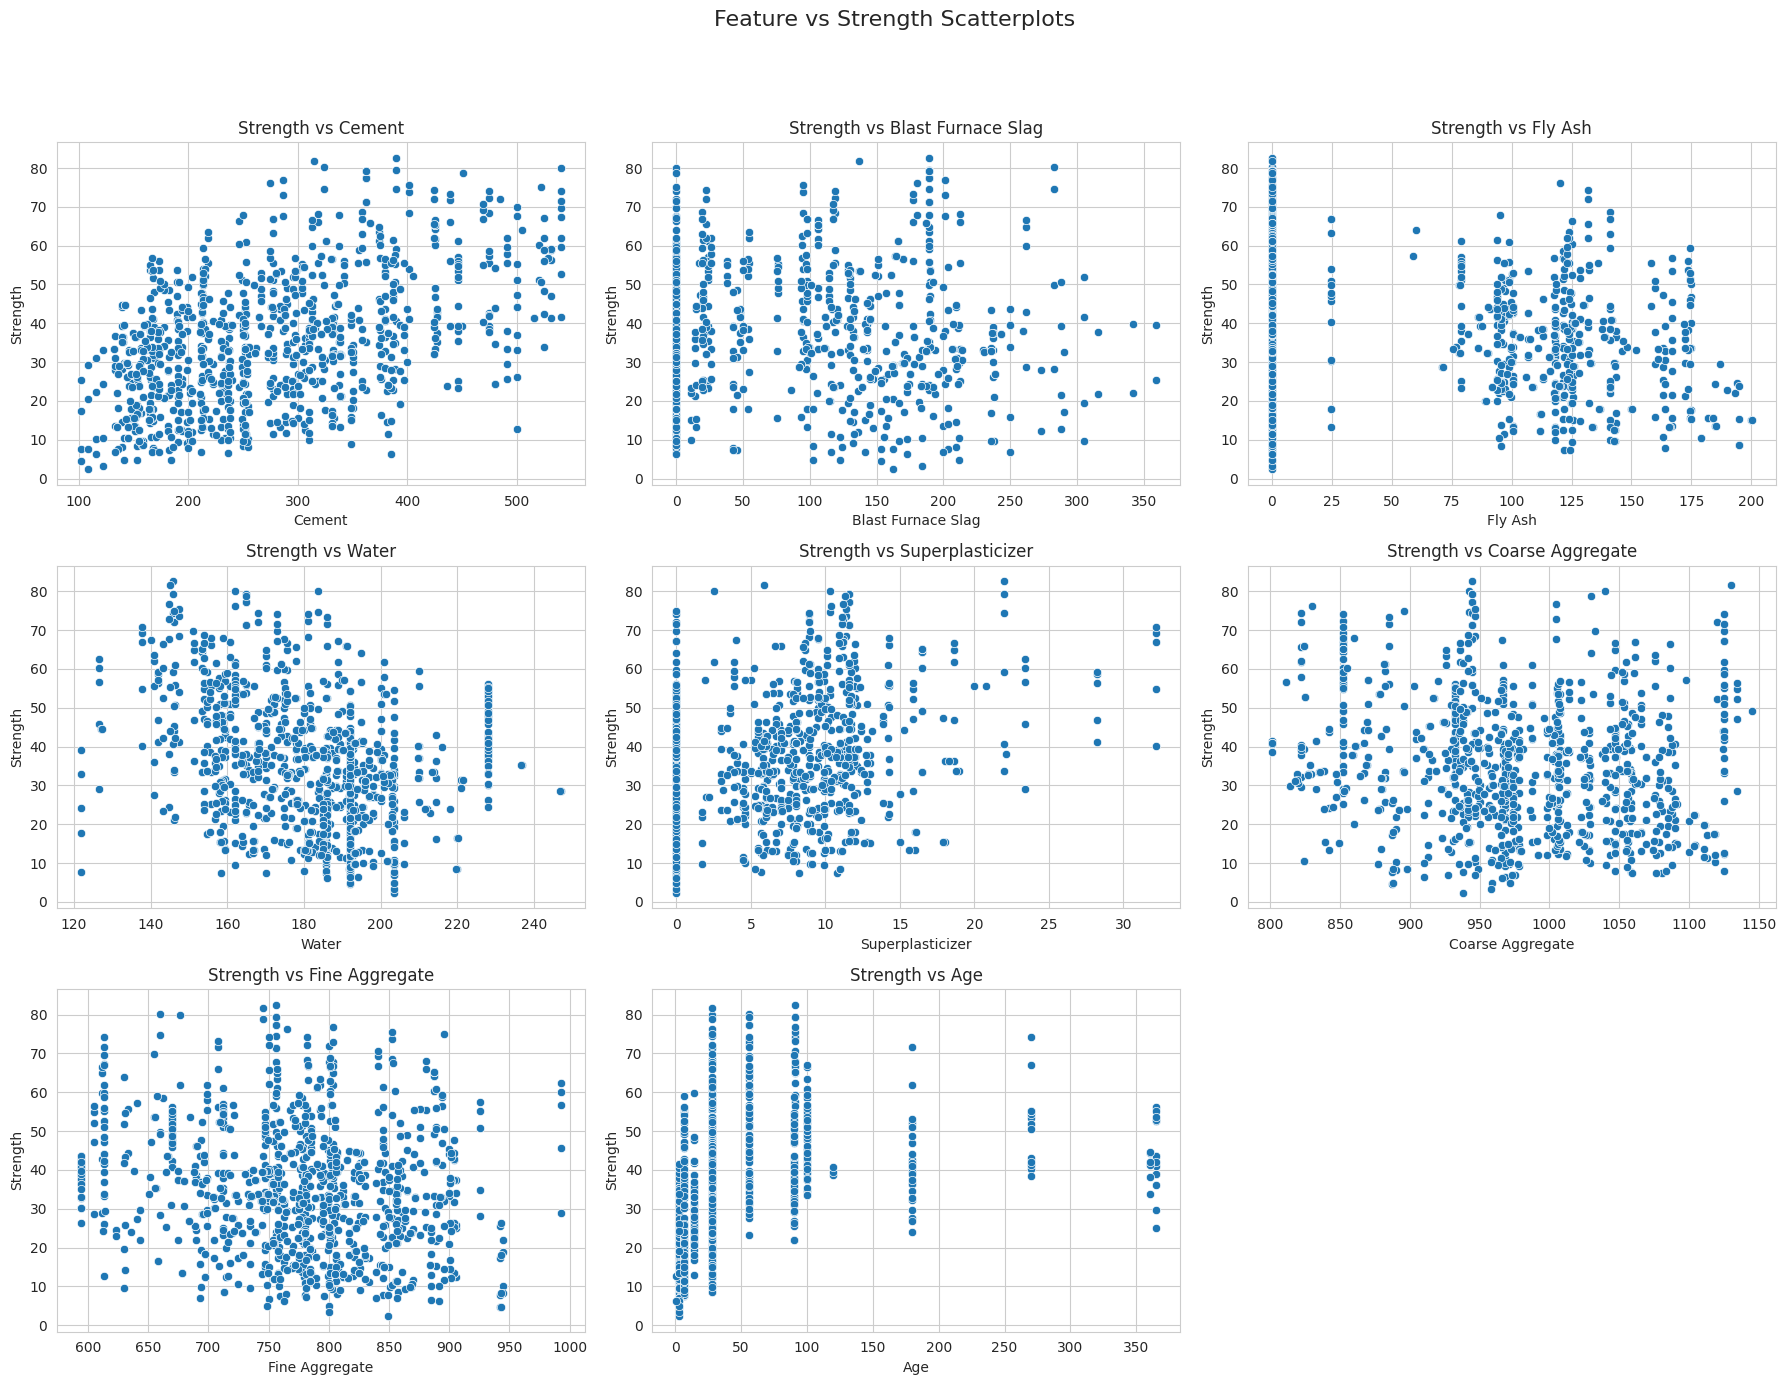

In [8]:
# Feature vs Target (Strength)
target_variable = 'Strength'
feature_columns = [col for col in df.columns if col != target_variable]

num_features = len(feature_columns)
num_cols_subplot = 3
num_rows_subplot = (num_features + num_cols_subplot - 1) // num_cols_subplot

plt.figure(figsize=(num_cols_subplot * 6, num_rows_subplot * 5))
plt.suptitle(f'Feature vs {target_variable} Scatterplots', fontsize=16, y=1.02)

for i, feature in enumerate(feature_columns):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    sns.scatterplot(x=df[feature], y=df[target_variable])
    plt.title(f'{target_variable} vs {feature}')
    plt.xlabel(feature)
    plt.ylabel(target_variable)

plt.tight_layout(rect=[0, 0.1, 1, 0.98])
plt.show()

In [9]:
#  REGRESSION TASK

X = df.drop('Strength', axis=1)
y = df['Strength']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)

# Train-test splits: 70:30 and 80:20
X_train_70, X_test_70, y_train_70, y_test_70 = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_train_80, X_test_80, y_train_80, y_test_80 = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Copies for linear and polynomial setups
X_train_70_lin  = X_train_70.copy(deep=True)
X_test_70_lin   = X_test_70.copy(deep=True)
y_train_70_lin  = y_train_70.copy(deep=True)
y_test_70_lin   = y_test_70.copy(deep=True)

X_train_70_poly = X_train_70.copy(deep=True)
X_test_70_poly  = X_test_70.copy(deep=True)
y_train_70_poly = y_train_70.copy(deep=True)
y_test_70_poly  = y_test_70.copy(deep=True)

X_train_80_lin  = X_train_80.copy(deep=True)
X_test_80_lin   = X_test_80.copy(deep=True)
y_train_80_lin  = y_train_80.copy(deep=True)
y_test_80_lin   = y_test_80.copy(deep=True)

X_train_80_poly = X_train_80.copy(deep=True)
X_test_80_poly  = X_test_80.copy(deep=True)
y_train_80_poly = y_train_80.copy(deep=True)
y_test_80_poly  = y_test_80.copy(deep=True)

print("70:30 linear X_train shape:", X_train_70_lin.shape)
print("70:30 poly   X_train shape:", X_train_70_poly.shape)
print("80:20 linear X_train shape:", X_train_80_lin.shape)
print("80:20 poly   X_train shape:", X_train_80_poly.shape)

# 3.3 Scaling (linear)
scaler_70 = StandardScaler()
X_train_70_lin_scaled = scaler_70.fit_transform(X_train_70_lin)
X_test_70_lin_scaled = scaler_70.transform(X_test_70_lin)

scaler_80 = StandardScaler()
X_train_80_lin_scaled = scaler_80.fit_transform(X_train_80_lin)
X_test_80_lin_scaled = scaler_80.transform(X_test_80_lin)

print("\nScaled 70:30 shapes:", X_train_70_lin_scaled.shape, X_test_70_lin_scaled.shape)
print("Scaled 80:20 shapes:", X_train_80_lin_scaled.shape, X_test_80_lin_scaled.shape)

# 3.4 Polynomial / engineered features for regression
def add_concrete_poly_features(X):
    X = X.copy()
    X["Water_Cement_Ratio"] = X["Water"] / X["Cement"]
    X["Binder"] = X["Cement"] + X["Blast Furnace Slag"] + X["Fly Ash"]
    X["Aggregate_Ratio"] = X["Coarse Aggregate"] / X["Fine Aggregate"]
    X["SP_per_Binder"] = X["Superplasticizer"] / (X["Binder"] + 1e-8)
    X["Log_Age"] = np.log1p(X["Age"])
    X["Sqrt_Age"] = np.sqrt(X["Age"])

    X["Cement_Sq"] = X["Cement"]**2
    X["Water_Sq"] = X["Water"]**2
    X["Age_Sq"]   = X["Age"]**2
    X["Binder_Sq"] = X["Binder"]**2

    X["Cement_Water"] = X["Cement"] * X["Water"]
    X["Cement_Age"] = X["Cement"] * X["Age"]
    X["Water_Age"] = X["Water"] * X["Age"]
    X["Binder_Water"] = X["Binder"] * X["Water"]
    X["Binder_Age"] = X["Binder"] * X["Age"]
    X["SP_Cement"] = X["Superplasticizer"] * X["Cement"]
    X["SP_Water"] = X["Superplasticizer"] * X["Water"]

    return X

X_train_70_poly = add_concrete_poly_features(X_train_70_poly)
X_test_70_poly  = add_concrete_poly_features(X_test_70_poly)
print("\n70:30 polynomial feature shape:", X_train_70_poly.shape)

X_train_80_poly = add_concrete_poly_features(X_train_80_poly)
X_test_80_poly  = add_concrete_poly_features(X_test_80_poly)
print("80:20 polynomial feature shape:", X_train_80_poly.shape)

# Scaling polynomial sets
scaler_70_poly = StandardScaler()
X_train_70_poly_scaled = scaler_70_poly.fit_transform(X_train_70_poly)
X_test_70_poly_scaled = scaler_70_poly.transform(X_test_70_poly)

scaler_80_poly = StandardScaler()
X_train_80_poly_scaled = scaler_80_poly.fit_transform(X_train_80_poly)
X_test_80_poly_scaled = scaler_80_poly.transform(X_test_80_poly)

print("\nScaled 70:30 poly:", X_train_70_poly_scaled.shape, X_test_70_poly_scaled.shape)
print("Scaled 80:20 poly:", X_train_80_poly_scaled.shape, X_test_80_poly_scaled.shape)



Features (X) shape: (1030, 8)
Target (y) shape: (1030,)
70:30 linear X_train shape: (721, 8)
70:30 poly   X_train shape: (721, 8)
80:20 linear X_train shape: (824, 8)
80:20 poly   X_train shape: (824, 8)

Scaled 70:30 shapes: (721, 8) (309, 8)
Scaled 80:20 shapes: (824, 8) (206, 8)

70:30 polynomial feature shape: (721, 25)
80:20 polynomial feature shape: (824, 25)

Scaled 70:30 poly: (721, 25) (309, 25)
Scaled 80:20 poly: (824, 25) (206, 25)


In [10]:
# Helper functions for regression

def to_numpy(X):
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.to_numpy()
    return np.array(X)

def add_bias(X):
    X_np = to_numpy(X)
    if X_np.ndim == 1:
        X_np = X_np.reshape(-1, 1)
    ones = np.ones((X_np.shape[0], 1))
    return np.concatenate((ones, X_np), axis=1)

def mse(y_true, y_pred):
    y_true_np = to_numpy(y_true).ravel()
    y_pred_np = to_numpy(y_pred).ravel()
    return np.mean((y_true_np - y_pred_np)**2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def r2_score_manual(y_true, y_pred):
    y_true_np = to_numpy(y_true).ravel()
    y_pred_np = to_numpy(y_pred).ravel()
    ss_total = np.sum((y_true_np - np.mean(y_true_np))**2)
    ss_residual = np.sum((y_true_np - y_pred_np)**2)
    if ss_total == 0:
        return 1.0 if ss_residual == 0 else 0.0
    return 1 - (ss_residual / ss_total)

In [11]:
# Linear Regression via Normal Equation (from scratch)

def normal_equation(X, y):
    X_b = add_bias(X)
    y_np = to_numpy(y)
    try:
        theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y_np
    except np.linalg.LinAlgError:
        print("Warning: Singular matrix. Using pseudo-inverse.")
        theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y_np
    return theta

normal_equation_results = []

# 70:30 Linear
theta_70_lin = normal_equation(X_train_70_lin_scaled, y_train_70_lin)
y_train_pred_70_lin = add_bias(X_train_70_lin_scaled) @ theta_70_lin
y_test_pred_70_lin = add_bias(X_test_70_lin_scaled) @ theta_70_lin

normal_equation_results.append({
    "Dataset": "70:30 Linear",
    "Model": "Normal Equation",
    "Train MSE": mse(y_train_70_lin, y_train_pred_70_lin),
    "Train RMSE": rmse(y_train_70_lin, y_train_pred_70_lin),
    "Train R2": r2_score_manual(y_train_70_lin, y_train_pred_70_lin),
    "Test MSE": mse(y_test_70_lin, y_test_pred_70_lin),
    "Test RMSE": rmse(y_test_70_lin, y_test_pred_70_lin),
    "Test R2": r2_score_manual(y_test_70_lin, y_test_pred_70_lin),
})

# 80:20 Linear
theta_80_lin = normal_equation(X_train_80_lin_scaled, y_train_80_lin)
y_train_pred_80_lin = add_bias(X_train_80_lin_scaled) @ theta_80_lin
y_test_pred_80_lin = add_bias(X_test_80_lin_scaled) @ theta_80_lin

normal_equation_results.append({
    "Dataset": "80:20 Linear",
    "Model": "Normal Equation",
    "Train MSE": mse(y_train_80_lin, y_train_pred_80_lin),
    "Train RMSE": rmse(y_train_80_lin, y_train_pred_80_lin),
    "Train R2": r2_score_manual(y_train_80_lin, y_train_pred_80_lin),
    "Test MSE": mse(y_test_80_lin, y_test_pred_80_lin),
    "Test RMSE": rmse(y_test_80_lin, y_test_pred_80_lin),
    "Test R2": r2_score_manual(y_test_80_lin, y_test_pred_80_lin),
})

# 70:30 Polynomial
theta_70_poly = normal_equation(X_train_70_poly_scaled, y_train_70_poly)
y_train_pred_70_poly = add_bias(X_train_70_poly_scaled) @ theta_70_poly
y_test_pred_70_poly = add_bias(X_test_70_poly_scaled) @ theta_70_poly

normal_equation_results.append({
    "Dataset": "70:30 Polynomial",
    "Model": "Normal Equation",
    "Train MSE": mse(y_train_70_poly, y_train_pred_70_poly),
    "Train RMSE": rmse(y_train_70_poly, y_train_pred_70_poly),
    "Train R2": r2_score_manual(y_train_70_poly, y_train_pred_70_poly),
    "Test MSE": mse(y_test_70_poly, y_test_pred_70_poly),
    "Test RMSE": rmse(y_test_70_poly, y_test_pred_70_poly),
    "Test R2": r2_score_manual(y_test_70_poly, y_test_pred_70_poly),
})

# 80:20 Polynomial
theta_80_poly = normal_equation(X_train_80_poly_scaled, y_train_80_poly)
y_train_pred_80_poly = add_bias(X_train_80_poly_scaled) @ theta_80_poly
y_test_pred_80_poly = add_bias(X_test_80_poly_scaled) @ theta_80_poly

normal_equation_results.append({
    "Dataset": "80:20 Polynomial",
    "Model": "Normal Equation",
    "Train MSE": mse(y_train_80_poly, y_train_pred_80_poly),
    "Train RMSE": rmse(y_train_80_poly, y_train_pred_80_poly),
    "Train R2": r2_score_manual(y_train_80_poly, y_train_pred_80_poly),
    "Test MSE": mse(y_test_80_poly, y_test_pred_80_poly),
    "Test RMSE": rmse(y_test_80_poly, y_test_pred_80_poly),
    "Test R2": r2_score_manual(y_test_80_poly, y_test_pred_80_poly),
})

results_df_ne = pd.DataFrame(normal_equation_results)
print("\n--- Normal Equation Model Performance ---")
display(results_df_ne)



--- Normal Equation Model Performance ---


Dataset            Model   Train MSE  Train RMSE  Train R2  \
0      70:30 Linear  Normal Equation  107.239939   10.355672  0.619672   
1      80:20 Linear  Normal Equation  110.644887   10.518787  0.610524   
2  70:30 Polynomial  Normal Equation   43.275860    6.578439  0.846522   
3  80:20 Polynomial  Normal Equation   44.701529    6.685920  0.842648   

     Test MSE  Test RMSE   Test R2  
0  109.750808  10.476202  0.594378  
1   95.970940   9.796476  0.627553  
2   49.827202   7.058839  0.815846  
3   45.160971   6.720191  0.824738


--- Ridge Regression Model Performance (alpha=1.0) ---


Dataset             Model   Train MSE  Train RMSE  Train R2  \
0      70:30 Linear  Ridge Regression  107.252819   10.356294  0.619627   
1      80:20 Linear  Ridge Regression  110.652256   10.519138  0.610498   
2  70:30 Polynomial  Ridge Regression   42.454236    6.515692  0.849436   
3  80:20 Polynomial  Ridge Regression   43.783565    6.616915  0.845879   

     Test MSE  Test RMSE   Test R2  
0  109.562276  10.467200  0.595075  
1   95.965107   9.796178  0.627576  
2   47.276477   6.875789  0.825274  
3   41.837959   6.468227  0.837634


Running custom GridSearch for Ridge on: 70:30 Linear
Best alpha for 70:30 Linear: 10.0 (Test RMSE: 10.4445)

Running custom GridSearch for Ridge on: 80:20 Linear
Best alpha for 80:20 Linear: 1.0 (Test RMSE: 9.7962)

Running custom GridSearch for Ridge on: 70:30 Polynomial
Best alpha for 70:30 Polynomial: 0.1 (Test RMSE: 6.8644)

Running custom GridSearch for Ridge on: 80:20 Polynomial
Best alpha for 80:20 Polynomial: 2.0 (Test RMSE: 6.4593)

--- Custom Ridge Regression GridSearch Performance ---


Dataset             Model  CV RMSE  Test MSE  Test RMSE  Test R2
0      70:30 Linear  Ridge Regression  10.3890  109.0886    10.4445   0.5968
1      80:20 Linear  Ridge Regression  10.5191   95.9651     9.7962   0.6276
2  70:30 Polynomial  Ridge Regression   6.4835   47.1203     6.8644   0.8259
3  80:20 Polynomial  Ridge Regression   6.6524   41.7222     6.4593   0.8381

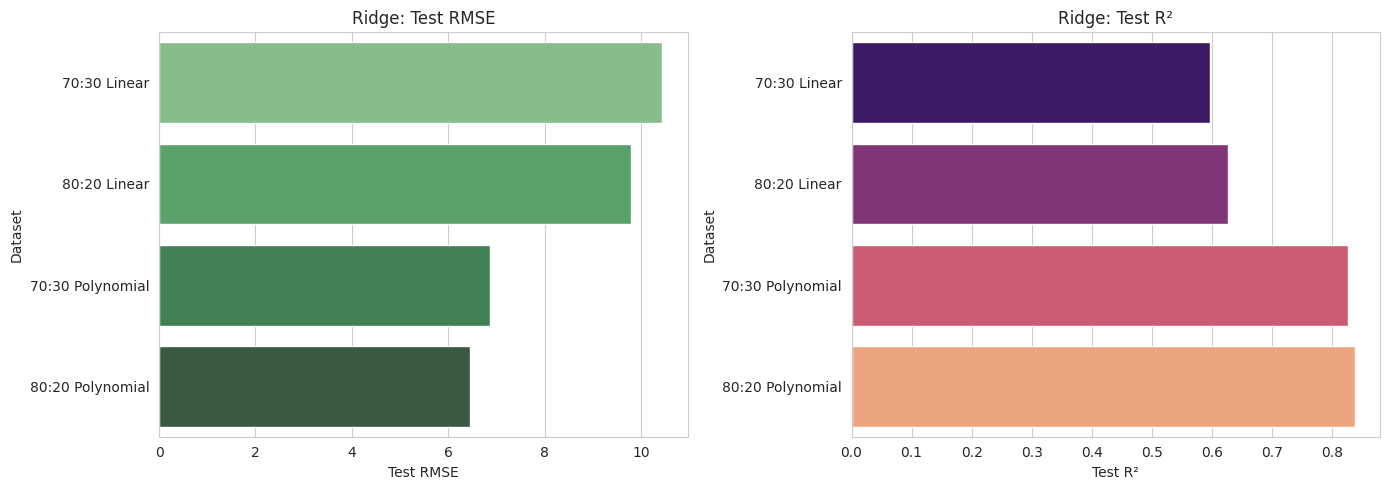

In [12]:
# Ridge Regression (from scratch) + tuning

def ridge_regression(X, y, alpha):
    X_b = add_bias(X)
    y_np = to_numpy(y)
    num_features = X_b.shape[1]
    I = np.identity(num_features)
    I[0, 0] = 0
    try:
        theta = np.linalg.inv(X_b.T @ X_b + alpha * I) @ X_b.T @ y_np
    except np.linalg.LinAlgError:
        print("Warning: singular matrix in Ridge. Using pinv.")
        theta = np.linalg.pinv(X_b.T @ X_b + alpha * I) @ X_b.T @ y_np
    return theta

ridge_results = []

data_configurations = [
    (X_train_70_lin_scaled, X_test_70_lin_scaled, y_train_70_lin, y_test_70_lin, "70:30 Linear"),
    (X_train_80_lin_scaled, X_test_80_lin_scaled, y_train_80_lin, y_test_80_lin, "80:20 Linear"),
    (X_train_70_poly_scaled, X_test_70_poly_scaled, y_train_70_poly, y_test_70_poly, "70:30 Polynomial"),
    (X_train_80_poly_scaled, X_test_80_poly_scaled, y_train_80_poly, y_test_80_poly, "80:20 Polynomial"),
]

default_alpha = 1.0

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    theta = ridge_regression(X_train_r, y_train_r, default_alpha)
    y_train_pred = add_bias(X_train_r) @ theta
    y_test_pred = add_bias(X_test_r) @ theta

    ridge_results.append({
        "Dataset": dataset_name,
        "Model": "Ridge Regression",
        "Train MSE": mse(y_train_r, y_train_pred),
        "Train RMSE": rmse(y_train_r, y_train_pred),
        "Train R2": r2_score_manual(y_train_r, y_train_pred),
        "Test MSE": mse(y_test_r, y_test_pred),
        "Test RMSE": rmse(y_test_r, y_test_pred),
        "Test R2": r2_score_manual(y_test_r, y_test_pred),
    })

results_df_ridge = pd.DataFrame(ridge_results)
print("\n--- Ridge Regression Model Performance (alpha=1.0) ---")
display(results_df_ridge)

# Custom grid search for Ridge
ridge_grid_results = []
alpha_grid = [1e-3, 1e-2, 0.01, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0]

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    print(f"\nRunning custom GridSearch for Ridge on: {dataset_name}")
    best_test_rmse = float('inf')
    best_alpha = None
    best_train_rmse = None
    best_test_mse = None
    best_test_r2 = None

    for alpha in alpha_grid:
        theta = ridge_regression(X_train_r, y_train_r, alpha)
        y_train_pred = add_bias(X_train_r) @ theta
        y_test_pred = add_bias(X_test_r) @ theta

        current_test_rmse = rmse(y_test_r, y_test_pred)
        if current_test_rmse < best_test_rmse:
            best_test_rmse = current_test_rmse
            best_alpha = alpha
            best_train_rmse = rmse(y_train_r, y_train_pred)
            best_test_mse = mse(y_test_r, y_test_pred)
            best_test_r2 = r2_score_manual(y_test_r, y_test_pred)

    ridge_grid_results.append({
        "Dataset": dataset_name,
        "Model": "Ridge Regression",
        "CV RMSE": round(best_train_rmse, 4),   # train-side RMSE as proxy
        "Test MSE": round(best_test_mse, 4),
        "Test RMSE": round(best_test_rmse, 4),
        "Test R2": round(best_test_r2, 4)
    })
    print(f"Best alpha for {dataset_name}: {best_alpha} (Test RMSE: {best_test_rmse:.4f})")

results_df_ridge_grid = pd.DataFrame(ridge_grid_results)
print("\n--- Custom Ridge Regression GridSearch Performance ---")
display(results_df_ridge_grid)

# Simple barplots for tuned ridge
summary_df = results_df_ridge_grid.copy()
summary_df["Test RMSE"] = summary_df["Test RMSE"].astype(float)
summary_df["Test R2"] = summary_df["Test R2"].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(y="Dataset", x="Test RMSE", data=summary_df, hue="Dataset", legend=False, palette="Greens_d", ax=axes[0])
axes[0].set_title("Ridge: Test RMSE")
axes[0].set_xlabel("Test RMSE")

sns.barplot(y="Dataset", x="Test R2", data=summary_df, hue="Dataset", legend=False, palette="magma", ax=axes[1])
axes[1].set_title("Ridge: Test R²")
axes[1].set_xlabel("Test R²")

plt.tight_layout()
plt.show()

In [13]:
# Lasso Regression (from scratch) + tuning

def soft_threshold(rho, lambd):
    if rho > lambd:
        return rho - lambd
    elif rho < -lambd:
        return rho + lambd
    else:
        return 0.0

def lasso_regression_from_scratch(X, y, alpha, max_iters=1000, tol=1e-4):
    X_np = to_numpy(X)
    y_np = to_numpy(y).reshape(-1, 1)
    X_b = add_bias(X_np)
    n_samples, n_features = X_b.shape
    w = np.zeros((n_features, 1))

    for _ in range(max_iters):
        w_old = w.copy()

        # update intercept separately
        y_pred_no_bias = X_b[:, 1:] @ w[1:]
        w[0] = np.sum(y_np - y_pred_no_bias) / n_samples

        for j in range(1, n_features):
            y_pred_all = X_b @ w
            residual_j = y_np - y_pred_all + X_b[:, j:j+1] * w[j]
            rho_j = np.sum(X_b[:, j:j+1] * residual_j)
            zj = np.sum(X_b[:, j:j+1]**2)
            if zj == 0:
                w[j] = 0.0
            else:
                w[j] = soft_threshold(rho_j, alpha * n_samples) / zj

        if np.max(np.abs(w - w_old)) < tol:
            break

    return w.flatten()

lasso_results = []

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    theta_lasso = lasso_regression_from_scratch(X_train_r, y_train_r, alpha=1.0)
    y_train_pred = add_bias(X_train_r) @ theta_lasso
    y_test_pred = add_bias(X_test_r) @ theta_lasso

    lasso_results.append({
        "Dataset": dataset_name,
        "Model": "Lasso Regression",
        "Train MSE": mse(y_train_r, y_train_pred),
        "Train RMSE": rmse(y_train_r, y_train_pred),
        "Train R2": r2_score_manual(y_train_r, y_train_pred),
        "Test MSE": mse(y_test_r, y_test_pred),
        "Test RMSE": rmse(y_test_r, y_test_pred),
        "Test R2": r2_score_manual(y_test_r, y_test_pred),
    })
    print(f"Results for {dataset_name} (Lasso alpha=1.0) stored.")

results_df_lasso = pd.DataFrame(lasso_results)
print("\n--- Lasso Regression Model Performance (alpha=1.0) ---")
display(results_df_lasso)

# Custom grid search for Lasso
lasso_grid_results = []
param_grid_custom_lasso = {
    "alpha": [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 2.0, 5.0, 10.0],
    "tol": [1e-2, 1e-3, 1e-4, 1e-5]
}

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    print(f"\nRunning custom GridSearch for Lasso on: {dataset_name}")
    best_test_rmse = float('inf')
    best_alpha, best_tol = None, None
    best_train_rmse = None
    best_test_mse = None
    best_test_r2 = None

    for alpha in param_grid_custom_lasso["alpha"]:
        for tol in param_grid_custom_lasso["tol"]:
            theta = lasso_regression_from_scratch(X_train_r, y_train_r, alpha, tol=tol)
            y_train_pred = add_bias(X_train_r) @ theta
            y_test_pred = add_bias(X_test_r) @ theta

            current_test_rmse = rmse(y_test_r, y_test_pred)
            if current_test_rmse < best_test_rmse:
                best_test_rmse = current_test_rmse
                best_alpha, best_tol = alpha, tol
                best_train_rmse = rmse(y_train_r, y_train_pred)
                best_test_mse = mse(y_test_r, y_test_pred)
                best_test_r2 = r2_score_manual(y_test_r, y_test_pred)

    lasso_grid_results.append({
        "Dataset": dataset_name,
        "Model": "Lasso Regression",
        "CV RMSE": round(best_train_rmse, 4),
        "Test MSE": round(best_test_mse, 4),
        "Test RMSE": round(best_test_rmse, 4),
        "Test R2": round(best_test_r2, 4)
    })
    print(f"Best params for {dataset_name}: alpha={best_alpha}, tol={best_tol} (Test RMSE: {best_test_rmse:.4f})")

results_df_lasso_grid = pd.DataFrame(lasso_grid_results)
print("\n--- Custom Lasso Regression GridSearch Performance ---")
display(results_df_lasso_grid)


Results for 70:30 Linear (Lasso alpha=1.0) stored.
Results for 80:20 Linear (Lasso alpha=1.0) stored.
Results for 70:30 Polynomial (Lasso alpha=1.0) stored.
Results for 80:20 Polynomial (Lasso alpha=1.0) stored.

--- Lasso Regression Model Performance (alpha=1.0) ---


Dataset             Model   Train MSE  Train RMSE  Train R2  \
0      70:30 Linear  Lasso Regression  119.376780   10.925968  0.576629   
1      80:20 Linear  Lasso Regression  122.897452   11.085912  0.567394   
2  70:30 Polynomial  Lasso Regression   56.475401    7.515012  0.799709   
3  80:20 Polynomial  Lasso Regression   57.581841    7.588270  0.797309   

     Test MSE  Test RMSE   Test R2  
0  124.937939  11.177564  0.538249  
1  112.369494  10.600448  0.563913  
2   53.766952   7.332595  0.801286  
3   46.488854   6.818274  0.819585


Running custom GridSearch for Lasso on: 70:30 Linear
Best params for 70:30 Linear: alpha=0.1, tol=0.01 (Test RMSE: 10.4279)

Running custom GridSearch for Lasso on: 80:20 Linear
Best params for 80:20 Linear: alpha=0.001, tol=0.01 (Test RMSE: 9.7953)

Running custom GridSearch for Lasso on: 70:30 Polynomial
Best params for 70:30 Polynomial: alpha=0.01, tol=0.001 (Test RMSE: 6.8558)

Running custom GridSearch for Lasso on: 80:20 Polynomial
Best params for 80:20 Polynomial: alpha=0.01, tol=0.01 (Test RMSE: 6.4583)

--- Custom Lasso Regression GridSearch Performance ---


Dataset             Model  CV RMSE  Test MSE  Test RMSE  Test R2
0      70:30 Linear  Lasso Regression  10.4122  108.7401    10.4279   0.5981
1      80:20 Linear  Lasso Regression  10.5190   95.9485     9.7953   0.6276
2  70:30 Polynomial  Lasso Regression   6.5174   47.0018     6.8558   0.8263
3  80:20 Polynomial  Lasso Regression   6.6189   41.7097     6.4583   0.8381

In [14]:
# SVR, XGBoost, LightGBM (baseline + tuned)

# --- SVR baseline ---
svr_results = []

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
    svr_model.fit(X_train_r, y_train_r)

    y_train_pred = svr_model.predict(X_train_r)
    y_test_pred = svr_model.predict(X_test_r)

    svr_results.append({
        "Dataset": dataset_name,
        "Model": "SVR",
        "Train MSE": mean_squared_error(y_train_r, y_train_pred),
        "Train RMSE": rmse(y_train_r, y_train_pred),
        "Train R2": r2_score_manual(y_train_r, y_train_pred),
        "Test MSE": mean_squared_error(y_test_r, y_test_pred),
        "Test RMSE": rmse(y_test_r, y_test_pred),
        "Test R2": r2_score_manual(y_test_r, y_test_pred),
    })
    print(f"Results for {dataset_name} (SVR baseline) stored.")

results_df_svr = pd.DataFrame(svr_results)
print("\n--- SVR Baseline Performance ---")
display(results_df_svr)

# --- SVR tuned via GridSearchCV ---
svr_grid_results = []
svr_param_grid = [
    {"kernel": ["rbf"], "C": [0.1, 1.0, 5.0, 10.0],
     "gamma": ["scale", "auto", 0.01, 0.001],
     "epsilon": [0.01, 0.05, 0.1, 0.5]},
    {"kernel": ["linear"], "C": [0.1, 1.0],
     "epsilon": [0.05, 0.1, 0.5]},
    {"kernel": ["poly"], "C": [0.1, 1.0, 5.0],
     "degree": [2, 3],
     "gamma": ["scale", "auto"],
     "epsilon": [0.05, 0.1]}
]

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    gs = GridSearchCV(
        estimator=SVR(),
        param_grid=svr_param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=0
    )
    gs.fit(X_train_r, y_train_r)

    best_neg_mse = gs.best_score_
    best_mse_cv = max(-best_neg_mse, 0.0)
    best_rmse_cv = float(np.sqrt(best_mse_cv))

    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test_r)
    test_mse = mean_squared_error(y_test_r, y_test_pred)
    test_rmse = float(np.sqrt(test_mse))
    test_r2 = float(r2_score(y_test_r, y_test_pred))

    svr_grid_results.append({
        "Dataset": dataset_name,
        "Model": "SVR",
        "CV RMSE": round(best_rmse_cv, 4),
        "Test MSE": round(test_mse, 4),
        "Test RMSE": round(test_rmse, 4),
        "Test R2": round(test_r2, 4),
    })

results_svr_grid_df = pd.DataFrame(svr_grid_results)
print("\n--- SVR GridSearchCV Performance ---")
display(results_svr_grid_df)

# --- XGBoost baseline ---
xgb_results = []

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train_r, y_train_r)

    y_train_pred = xgb_model.predict(X_train_r)
    y_test_pred = xgb_model.predict(X_test_r)

    xgb_results.append({
        "Dataset": dataset_name,
        "Model": "XGBoost",
        "Train MSE": mean_squared_error(y_train_r, y_train_pred),
        "Train RMSE": rmse(y_train_r, y_train_pred),
        "Train R2": r2_score_manual(y_train_r, y_train_pred),
        "Test MSE": mean_squared_error(y_test_r, y_test_pred),
        "Test RMSE": rmse(y_test_r, y_test_pred),
        "Test R2": r2_score_manual(y_test_r, y_test_pred),
    })
    print(f"Results for {dataset_name} (XGBoost baseline) stored.")

results_df_xgb = pd.DataFrame(xgb_results)
print("\n--- XGBoost Baseline Performance ---")
display(results_df_xgb)

# --- XGBoost tuned via GridSearchCV ---
xgb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5],
    "min_child_weight": [1, 3],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 10]
}

xgb_grid_results = []

for X_train_r, X_test_r, y_train_r, y_test_r, dataset_name in data_configurations:
    print(f"\nRunning XGBoost GridSearchCV for: {dataset_name}")
    xgb = XGBRegressor(objective="reg:squarederror", random_state=42, tree_method="hist")

    gs = GridSearchCV(
        estimator=xgb,
        param_grid=xgb_param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    gs.fit(X_train_r, y_train_r)

    best_neg_mse = gs.best_score_
    best_mse_cv = max(-best_neg_mse, 0.0)
    best_rmse_cv = float(np.sqrt(best_mse_cv))

    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test_r)
    test_mse = mean_squared_error(y_test_r, y_test_pred)
    test_rmse = float(np.sqrt(test_mse))
    test_r2 = float(r2_score(y_test_r, y_test_pred))

    xgb_grid_results.append({
        "Dataset": dataset_name,
        "Model": "XGBoost",
        "CV RMSE": round(best_rmse_cv, 4),
        "Test MSE": round(test_mse, 4),
        "Test RMSE": round(test_rmse, 4),
        "Test R2": round(test_r2, 4),
    })

results_xgb_grid_df = pd.DataFrame(xgb_grid_results)
print("\n--- XGBoost GridSearchCV Performance ---")
display(results_xgb_grid_df)

# --- LightGBM baseline ---
lgbm_results = []

original_feature_names_lin = X_train_70_lin.columns.tolist()
original_feature_names_poly = X_train_70_poly.columns.tolist()

for X_train_arr, X_test_arr, y_train_r, y_test_r, dataset_name in data_configurations:
    if "Linear" in dataset_name:
        feature_names = original_feature_names_lin
    else:
        feature_names = original_feature_names_poly

    X_train_r_df = pd.DataFrame(X_train_arr, columns=feature_names)
    X_test_r_df = pd.DataFrame(X_test_arr, columns=feature_names)

    lgbm_model = LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1, verbose=-1)
    lgbm_model.fit(X_train_r_df, y_train_r)

    y_train_pred = lgbm_model.predict(X_train_r_df)
    y_test_pred = lgbm_model.predict(X_test_r_df)

    lgbm_results.append({
        "Dataset": dataset_name,
        "Model": "LightGBM",
        "Train MSE": round(mean_squared_error(y_train_r, y_train_pred), 4),
        "Train RMSE": round(rmse(y_train_r, y_train_pred), 4),
        "Train R2": round(r2_score_manual(y_train_r, y_train_pred), 4),
        "Test MSE": round(mean_squared_error(y_test_r, y_test_pred), 4),
        "Test RMSE": round(rmse(y_test_r, y_test_pred), 4),
        "Test R2": round(r2_score_manual(y_test_r, y_test_pred), 4),
    })
    print(f"Results for {dataset_name} (LightGBM baseline) stored.")

results_df_lgbm = pd.DataFrame(lgbm_results)
print("\n--- LightGBM Baseline Performance ---")
display(results_df_lgbm)

# --- LightGBM tuned via GridSearchCV ---
lgbm_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 45],
    "max_depth": [-1, 5],
    "min_child_samples": [10, 20],
    "min_split_gain": [0.0, 0.1]
}

lgbm_grid_results = []

for X_train_arr, X_test_arr, y_train_r, y_test_r, dataset_name in data_configurations:
    print(f"\nRunning LightGBM GridSearchCV for: {dataset_name}")
    feature_names = original_feature_names_lin if "Linear" in dataset_name else original_feature_names_poly
    X_train_r_df = pd.DataFrame(X_train_arr, columns=feature_names)
    X_test_r_df = pd.DataFrame(X_test_arr, columns=feature_names)

    base_lgbm = LGBMRegressor(objective="regression", random_state=42, n_jobs=-1)

    gs = GridSearchCV(
        estimator=base_lgbm,
        param_grid=lgbm_param_grid,
        scoring="neg_mean_squared_error",
        cv=5,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    gs.fit(X_train_r_df, y_train_r)

    best_neg_mse = gs.best_score_
    best_mse_cv = max(-best_neg_mse, 0.0)
    best_rmse_cv = float(np.sqrt(best_mse_cv))

    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test_r_df)
    test_mse = mean_squared_error(y_test_r, y_test_pred)
    test_rmse = float(np.sqrt(test_mse))
    test_r2 = float(r2_score(y_test_r, y_test_pred))

    lgbm_grid_results.append({
        "Dataset": dataset_name,
        "Model": "LightGBM",
        "CV RMSE": round(best_rmse_cv, 4),
        "Test MSE": round(test_mse, 4),
        "Test RMSE": round(test_rmse, 4),
        "Test R2": round(test_r2, 4),
    })

results_lgbm_grid_df = pd.DataFrame(lgbm_grid_results)
print("\n--- LightGBM GridSearchCV Performance ---")
display(results_lgbm_grid_df)

Results for 70:30 Linear (SVR baseline) stored.
Results for 80:20 Linear (SVR baseline) stored.
Results for 70:30 Polynomial (SVR baseline) stored.
Results for 80:20 Polynomial (SVR baseline) stored.

--- SVR Baseline Performance ---


Dataset Model  Train MSE  Train RMSE  Train R2   Test MSE  \
0      70:30 Linear   SVR  19.665917    4.434627  0.930255  39.976618   
1      80:20 Linear   SVR  18.807422    4.336752  0.933797  32.805519   
2  70:30 Polynomial   SVR  13.024543    3.608953  0.953808  26.034261   
3  80:20 Polynomial   SVR  12.588659    3.548050  0.955687  27.480467   

   Test RMSE   Test R2  
0   6.322707  0.852253  
1   5.727610  0.872687  
2   5.102378  0.903781  
3   5.242182  0.893353


--- SVR GridSearchCV Performance ---


Dataset Model  CV RMSE  Test MSE  Test RMSE  Test R2
0      70:30 Linear   SVR   7.3283   57.9170     7.6103   0.7859
1      80:20 Linear   SVR   7.2071   51.1047     7.1488   0.8017
2  70:30 Polynomial   SVR   5.7338   31.0164     5.5692   0.8854
3  80:20 Polynomial   SVR   5.6130   28.5399     5.3423   0.8892

Results for 70:30 Linear (XGBoost baseline) stored.
Results for 80:20 Linear (XGBoost baseline) stored.
Results for 70:30 Polynomial (XGBoost baseline) stored.
Results for 80:20 Polynomial (XGBoost baseline) stored.

--- XGBoost Baseline Performance ---


Dataset    Model  Train MSE  Train RMSE  Train R2   Test MSE  \
0      70:30 Linear  XGBoost   2.648885    1.627539  0.990606  24.857558   
1      80:20 Linear  XGBoost   2.579200    1.605989  0.990921  24.698877   
2  70:30 Polynomial  XGBoost   1.783187    1.335360  0.993676  24.040827   
3  80:20 Polynomial  XGBoost   1.815361    1.347353  0.993610  28.440423   

   Test RMSE   Test R2  
0   4.985736  0.908130  
1   4.969796  0.904148  
2   4.903145  0.911149  
3   5.332956  0.889628


Running XGBoost GridSearchCV for: 70:30 Linear
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running XGBoost GridSearchCV for: 80:20 Linear
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running XGBoost GridSearchCV for: 70:30 Polynomial
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running XGBoost GridSearchCV for: 80:20 Polynomial
Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- XGBoost GridSearchCV Performance ---


Dataset    Model  CV RMSE  Test MSE  Test RMSE  Test R2
0      70:30 Linear  XGBoost   4.9295   21.9325     4.6832   0.9189
1      80:20 Linear  XGBoost   4.6661   19.3635     4.4004   0.9249
2  70:30 Polynomial  XGBoost   4.9447   20.7670     4.5571   0.9232
3  80:20 Polynomial  XGBoost   4.7358   22.7184     4.7664   0.9118

Results for 70:30 Linear (LightGBM baseline) stored.
Results for 80:20 Linear (LightGBM baseline) stored.
Results for 70:30 Polynomial (LightGBM baseline) stored.
Results for 80:20 Polynomial (LightGBM baseline) stored.

--- LightGBM Baseline Performance ---


Dataset     Model  Train MSE  Train RMSE  Train R2  Test MSE  \
0      70:30 Linear  LightGBM     5.2280      2.2865    0.9815   21.1791   
1      80:20 Linear  LightGBM     4.8676      2.2063    0.9829   22.5336   
2  70:30 Polynomial  LightGBM     3.3474      1.8296    0.9881   19.9264   
3  80:20 Polynomial  LightGBM     3.0909      1.7581    0.9891   22.0167   

   Test RMSE  Test R2  
0     4.6021   0.9217  
1     4.7470   0.9126  
2     4.4639   0.9264  
3     4.6922   0.9146


Running LightGBM GridSearchCV for: 70:30 Linear
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running LightGBM GridSearchCV for: 80:20 Linear
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running LightGBM GridSearchCV for: 70:30 Polynomial
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Running LightGBM GridSearchCV for: 80:20 Polynomial
Fitting 5 folds for each of 64 candidates, totalling 320 fits

--- LightGBM GridSearchCV Performance ---


Dataset     Model  CV RMSE  Test MSE  Test RMSE  Test R2
0      70:30 Linear  LightGBM   4.7844   18.7172     4.3263   0.9308
1      80:20 Linear  LightGBM   4.4472   21.0364     4.5865   0.9184
2  70:30 Polynomial  LightGBM   4.7843   19.5419     4.4206   0.9278
3  80:20 Polynomial  LightGBM   4.6032   21.8454     4.6739   0.9152


--- Combined Model Performance (Before Tuning) ---


Dataset             Model   Train MSE  Train RMSE  Train R2  \
0       70:30 Linear   Normal Equation  107.239939   10.355672  0.619672   
1       80:20 Linear   Normal Equation  110.644887   10.518787  0.610524   
2   70:30 Polynomial   Normal Equation   43.275860    6.578439  0.846522   
3   80:20 Polynomial   Normal Equation   44.701529    6.685920  0.842648   
4       70:30 Linear  Ridge Regression  107.252819   10.356294  0.619627   
5       80:20 Linear  Ridge Regression  110.652256   10.519138  0.610498   
6   70:30 Polynomial  Ridge Regression   42.454236    6.515692  0.849436   
7   80:20 Polynomial  Ridge Regression   43.783565    6.616915  0.845879   
8       70:30 Linear  Lasso Regression  119.376780   10.925968  0.576629   
9       80:20 Linear  Lasso Regression  122.897452   11.085912  0.567394   
10  70:30 Polynomial  Lasso Regression   56.475401    7.515012  0.799709   
11  80:20 Polynomial  Lasso Regression   57.581841    7.588270  0.797309   
12      70:30 Linear               SVR   19.665917    4.434627  0.930255   
13      80:20 Linear               SVR   18.807422    4.336752  0.933797   
14  70:30 Polynomial               SVR   13.024543    3.608953  0.953808   
15  80:20 Polynomial               SVR   12.588659    3.548050  0.955687   
16      70:30 Linear           XGBoost    2.648885    1.627539  0.990606   
17      80:20 Linear           XGBoost    2.579200    1.605989  0.990921   
18  70:30 Polynomial           XGBoost    1.783187    1.335360  0.993676   
19  80:20 Polynomial           XGBoost    1.815361    1.347353  0.993610   
20      70:30 Linear          LightGBM    5.228000    2.286500  0.981500   
21      80:20 Linear          LightGBM    4.867600    2.206300  0.982900   
22  70:30 Polynomial          LightGBM    3.347400    1.829600  0.988100   
23  80:20 Polynomial          LightGBM    3.090900    1.758100  0.989100   

      Test MSE  Test RMSE   Test R2  
0   109.750808  10.476202  0.594378  
1    95.970940   9.796476  0.627553  
2    49.827202   7.058839  0.815846  
3    45.160971   6.720191  0.824738  
4   109.562276  10.467200  0.595075  
5    95.965107   9.796178  0.627576  
6    47.276477   6.875789  0.825274  
7    41.837959   6.468227  0.837634  
8   124.937939  11.177564  0.538249  
9   112.369494  10.600448  0.563913  
10   53.766952   7.332595  0.801286  
11   46.488854   6.818274  0.819585  
12   39.976618   6.322707  0.852253  
13   32.805519   5.727610  0.872687  
14   26.034261   5.102378  0.903781  
15   27.480467   5.242182  0.893353  
16   24.857558   4.985736  0.908130  
17   24.698877   4.969796  0.904148  
18   24.040827   4.903145  0.911149  
19   28.440423   5.332956  0.889628  
20   21.179100   4.602100  0.921700  
21   22.533600   4.747000  0.912600  
22   19.926400   4.463900  0.926400  
23   22.016700   4.692200  0.914600

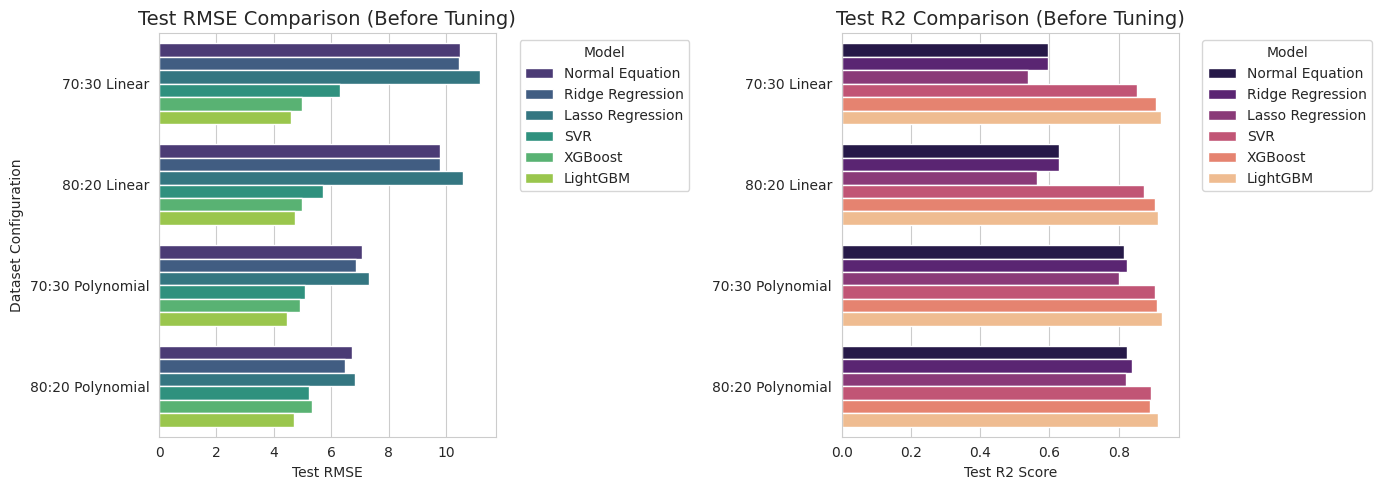


--- Combined Model Performance (After Tuning) ---


Dataset             Model  CV RMSE  Test MSE  Test RMSE  Test R2
0       70:30 Linear  Ridge Regression  10.3890  109.0886    10.4445   0.5968
1       80:20 Linear  Ridge Regression  10.5191   95.9651     9.7962   0.6276
2   70:30 Polynomial  Ridge Regression   6.4835   47.1203     6.8644   0.8259
3   80:20 Polynomial  Ridge Regression   6.6524   41.7222     6.4593   0.8381
4       70:30 Linear  Lasso Regression  10.4122  108.7401    10.4279   0.5981
5       80:20 Linear  Lasso Regression  10.5190   95.9485     9.7953   0.6276
6   70:30 Polynomial  Lasso Regression   6.5174   47.0018     6.8558   0.8263
7   80:20 Polynomial  Lasso Regression   6.6189   41.7097     6.4583   0.8381
8       70:30 Linear               SVR   7.3283   57.9170     7.6103   0.7859
9       80:20 Linear               SVR   7.2071   51.1047     7.1488   0.8017
10  70:30 Polynomial               SVR   5.7338   31.0164     5.5692   0.8854
11  80:20 Polynomial               SVR   5.6130   28.5399     5.3423   0.8892
12      70:30 Linear           XGBoost   4.9295   21.9325     4.6832   0.9189
13      80:20 Linear           XGBoost   4.6661   19.3635     4.4004   0.9249
14  70:30 Polynomial           XGBoost   4.9447   20.7670     4.5571   0.9232
15  80:20 Polynomial           XGBoost   4.7358   22.7184     4.7664   0.9118
16      70:30 Linear          LightGBM   4.7844   18.7172     4.3263   0.9308
17      80:20 Linear          LightGBM   4.4472   21.0364     4.5865   0.9184
18  70:30 Polynomial          LightGBM   4.7843   19.5419     4.4206   0.9278
19  80:20 Polynomial          LightGBM   4.6032   21.8454     4.6739   0.9152

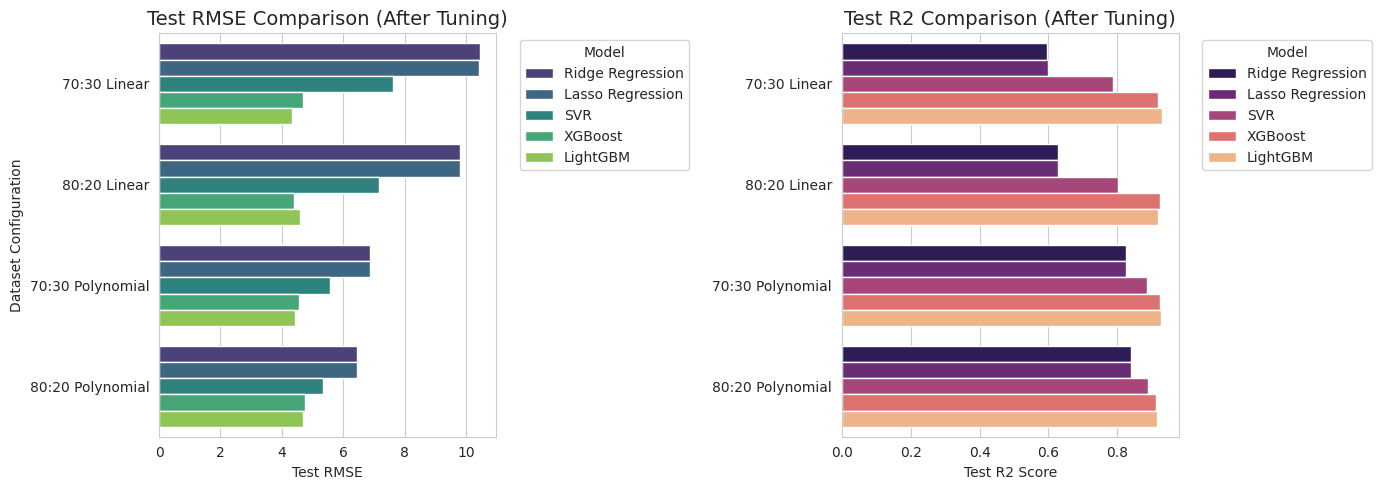

In [15]:
# Regression: Combined Comparison (Before & After Tuning)

combined_results_df = pd.concat([
    results_df_ne,
    results_df_ridge,
    results_df_lasso,
    results_df_svr,
    results_df_xgb,
    results_df_lgbm
]).reset_index(drop=True)

print("\n--- Combined Model Performance (Before Tuning) ---")
display(combined_results_df)

combined_results_df["Test RMSE"] = combined_results_df["Test RMSE"].astype(float)
combined_results_df["Test R2"] = combined_results_df["Test R2"].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=combined_results_df, x="Test RMSE", y="Dataset", hue="Model", palette="viridis", ax=axes[0])
axes[0].set_title('Test RMSE Comparison (Before Tuning)', fontsize=14)
axes[0].set_xlabel('Test RMSE')
axes[0].set_ylabel('Dataset Configuration')
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(data=combined_results_df, x="Test R2", y="Dataset", hue="Model", palette="magma", ax=axes[1])
axes[1].set_title('Test R2 Comparison (Before Tuning)', fontsize=14)
axes[1].set_xlabel('Test R2 Score')
axes[1].set_ylabel('')
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

combined_results_grid_df = pd.concat([
    results_df_ridge_grid,
    results_df_lasso_grid,
    results_svr_grid_df,
    results_xgb_grid_df,
    results_lgbm_grid_df
]).reset_index(drop=True)

print("\n--- Combined Model Performance (After Tuning) ---")
display(combined_results_grid_df)

combined_results_grid_df["Test RMSE"] = combined_results_grid_df["Test RMSE"].astype(float)
combined_results_grid_df["Test R2"] = combined_results_grid_df["Test R2"].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=combined_results_grid_df, x="Test RMSE", y="Dataset", hue="Model", palette="viridis", ax=axes[0])
axes[0].set_title('Test RMSE Comparison (After Tuning)', fontsize=14)
axes[0].set_xlabel('Test RMSE')
axes[0].set_ylabel('Dataset Configuration')
axes[0].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

sns.barplot(data=combined_results_grid_df, x="Test R2", y="Dataset", hue="Model", palette="magma", ax=axes[1])
axes[1].set_title('Test R2 Comparison (After Tuning)', fontsize=14)
axes[1].set_xlabel('Test R2 Score')
axes[1].set_ylabel('')
axes[1].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

##Classification


Class distribution:
 RCC_Suitable
1    655
0    375
Name: count, dtype: int64


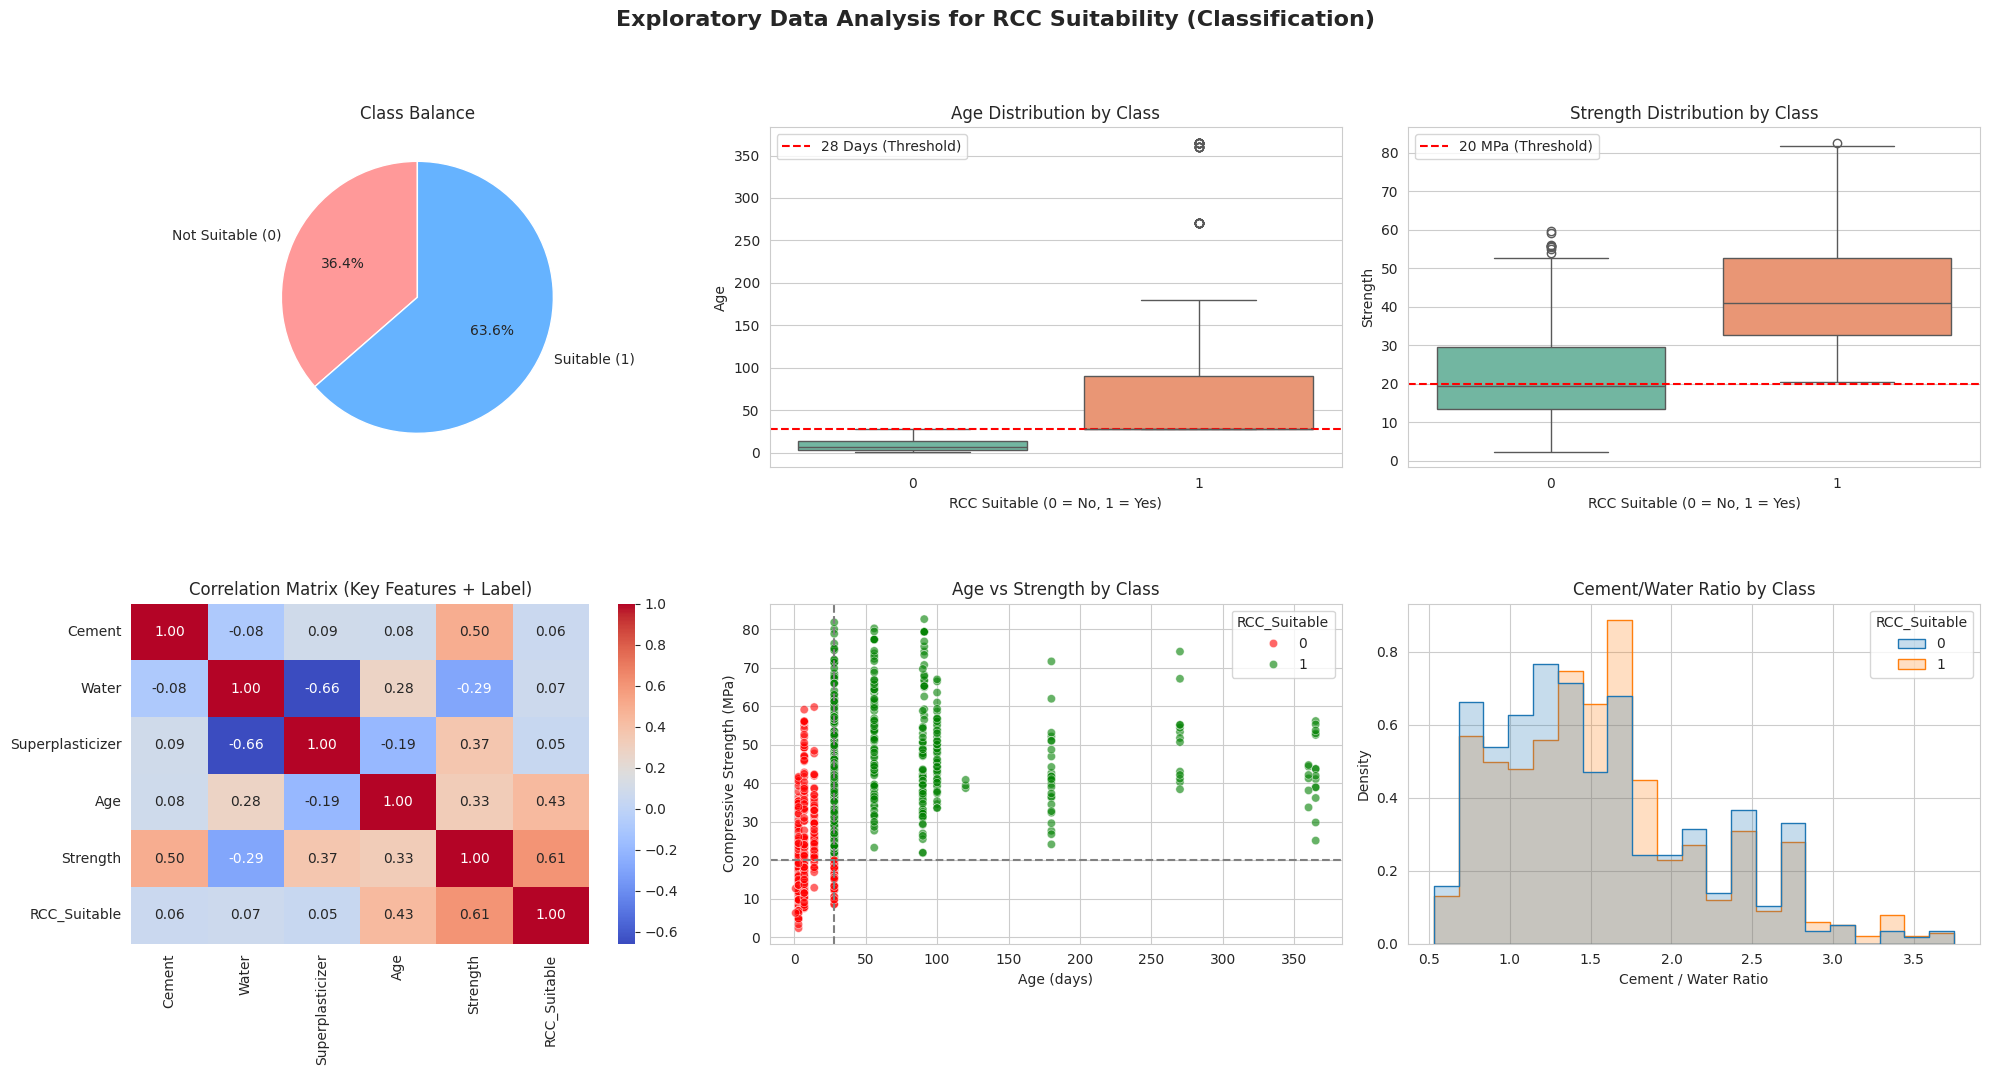

Class Imbalance Ratio (1:0) = 1.75:1


In [16]:
df['RCC_Suitable'] = ((df['Strength'] >= 20) & (df['Age'] >= 28)).astype(int)

print("Class distribution:\n", df['RCC_Suitable'].value_counts())

# Classification-focused EDA

plt.figure(figsize=(20, 15))
plt.suptitle("Exploratory Data Analysis for RCC Suitability (Classification)",
             fontsize=16, fontweight='bold')

# Class pie chart
plt.subplot(3, 3, 1)
class_counts = df['RCC_Suitable'].value_counts().sort_index()
plt.pie(
    class_counts,
    labels=['Not Suitable (0)', 'Suitable (1)'],
    autopct='%1.1f%%',
    colors=['#ff9999', '#66b3ff'],
    startangle=90
)
plt.title('Class Balance')

# Age boxplot
plt.subplot(3, 3, 2)
sns.boxplot(x='RCC_Suitable', y='Age', data=df, palette='Set2')
plt.axhline(y=28, color='red', linestyle='--', label='28 Days (Threshold)')
plt.title('Age Distribution by Class')
plt.xlabel('RCC Suitable (0 = No, 1 = Yes)')
plt.legend()

# Strength boxplot
plt.subplot(3, 3, 3)
sns.boxplot(x='RCC_Suitable', y='Strength', data=df, palette='Set2')
plt.axhline(y=20, color='red', linestyle='--', label='20 MPa (Threshold)')
plt.title('Strength Distribution by Class')
plt.xlabel('RCC Suitable (0 = No, 1 = Yes)')
plt.legend()

# Correlation heatmap (key features + label)
plt.subplot(3, 3, 4)
corr_cls = df[['Cement', 'Water', 'Superplasticizer', 'Age', 'Strength', 'RCC_Suitable']].corr()
sns.heatmap(corr_cls, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix (Key Features + Label)')

# Age vs Strength scatter
plt.subplot(3, 3, 5)
sns.scatterplot(
    x='Age', y='Strength',
    hue='RCC_Suitable', data=df,
    alpha=0.6, palette={0: 'red', 1: 'green'}
)
plt.axvline(x=28, color='gray', linestyle='--')
plt.axhline(y=20, color='gray', linestyle='--')
plt.title('Age vs Strength by Class')
plt.xlabel('Age (days)')
plt.ylabel('Compressive Strength (MPa)')

# Cement/Water ratio by class
plt.subplot(3, 3, 6)
if 'C_W_Ratio' not in df.columns:
    df['C_W_Ratio'] = df['Cement'] / df['Water']
sns.histplot(
    data=df,
    x='C_W_Ratio',
    hue='RCC_Suitable',
    element='step',
    stat='density',
    common_norm=False
)
plt.title('Cement/Water Ratio by Class')
plt.xlabel('Cement / Water Ratio')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

if 0 in class_counts and 1 in class_counts:
    print(f"Class Imbalance Ratio (1:0) = {class_counts[1] / class_counts[0]:.2f}:1")

In [17]:
# Feature Engineering & Preprocessing for Classification

eps = 1e-6

df['Cement_Water_Ratio'] = df['Cement'] / (df['Water'] + eps)
df['Total_Binder'] = df['Cement'] + df['Blast Furnace Slag'] + df['Fly Ash']
df['Water_Cement_Ratio'] = df['Water'] / (df['Cement'] + eps)
df['Total_Aggregate'] = df['Coarse Aggregate'] + df['Fine Aggregate']
df['Fine_Coarse_Ratio'] = df['Fine Aggregate'] / (df['Coarse Aggregate'] + eps)
df['Age_Log'] = np.log(df['Age'] + 1)

df['Binder_Aggregate_Ratio'] = df['Total_Binder'] / (df['Total_Aggregate'] + eps)
df['SP_per_Binder'] = df['Superplasticizer'] / (df['Total_Binder'] + eps)

features_list_cls = [
    'Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
    'Coarse Aggregate', 'Fine Aggregate', 'Age',
    'Cement_Water_Ratio', 'Total_Binder', 'Water_Cement_Ratio',
    'Total_Aggregate', 'Fine_Coarse_Ratio', 'Age_Log',
    'Binder_Aggregate_Ratio', 'SP_per_Binder'
]

X_cls = df[features_list_cls]
y_cls = df['RCC_Suitable']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

scaler_cls = StandardScaler()
X_train_cls_scaled = pd.DataFrame(scaler_cls.fit_transform(X_train_cls), columns=features_list_cls)
X_test_cls_scaled = pd.DataFrame(scaler_cls.transform(X_test_cls), columns=features_list_cls)

smote = SMOTE(random_state=42)
X_train_cls_res, y_train_cls_res = smote.fit_resample(X_train_cls_scaled, y_train_cls)

print("Classification Preprocessing Complete.")
print("Training Set Shape (after SMOTE):", X_train_cls_res.shape)
print("Test Set Shape:", X_test_cls_scaled.shape)


Classification Preprocessing Complete.
Training Set Shape (after SMOTE): (1048, 16)
Test Set Shape: (206, 16)


In [18]:
# Logistic Regression from Scratch (Classification)

class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.1, max_iterations=1000, tolerance=1e-6, penalty=None, C=1.0):
        self.lr = learning_rate
        self.max_iter = max_iterations
        self.tol = tolerance
        self.weights = None
        self.bias = None
        self.penalty = penalty
        self.alpha = 1 / C if C != 0 else 0
        self.cost_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def compute_loss(self, y, h, m):
        term1 = -y * np.log(h + 1e-15)
        term2 = -(1 - y) * np.log(1 - h + 1e-15)
        loss = (1/m) * np.sum(term1 + term2)

        if self.penalty == 'l2':
            loss += (self.alpha / (2*m)) * np.sum(np.square(self.weights))
        elif self.penalty == 'l1':
            loss += (self.alpha / m) * np.sum(np.abs(self.weights))
        return loss

    def fit(self, X, y):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.Series) else y
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for i in range(self.max_iter):
            z = np.dot(X, self.weights) + self.bias
            h = self.sigmoid(z)
            cost = self.compute_loss(y, h, m)
            self.cost_history.append(cost)

            dw = (1/m) * np.dot(X.T, (h - y))
            db = (1/m) * np.sum(h - y)

            if self.penalty == 'l2':
                dw += (self.alpha / m) * self.weights
            elif self.penalty == 'l1':
                dw += (self.alpha / m) * np.sign(self.weights)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if i > 0 and abs(self.cost_history[-2] - self.cost_history[-1]) < self.tol:
                break
        return self

    def predict_proba(self, X):
        X = X.values if isinstance(X, pd.DataFrame) else X
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

print("Custom Logistic Regression Class Initialized (Classification)")

Custom Logistic Regression Class Initialized (Classification)


In [19]:
# Benchmarking & Tuning (Classification)

models_cls = {
    'LogReg (Scratch L2)': LogisticRegressionScratch(penalty='l2', C=1.0),
    'LogReg (Scratch L1)': LogisticRegressionScratch(penalty='l1', C=1.0),
    'LogReg (Sklearn)': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Manual tuning of scratch LR
print("Tuning custom Logistic Regression (scratch)...")
C_grid = [0.01, 0.1, 1.0, 10.0]

X_s_train, X_s_val, y_s_train, y_s_val = train_test_split(
    X_train_cls_res, y_train_cls_res, test_size=0.2, random_state=42, stratify=y_train_cls_res
)

best_l2_f1, best_l2_C = -1, None
best_l1_f1, best_l1_C = -1, None

for C in C_grid:
    model = LogisticRegressionScratch(penalty='l2', C=C, learning_rate=0.1, max_iterations=2000)
    model.fit(X_s_train, y_s_train)
    y_val_prob = model.predict_proba(X_s_val)
    y_val_pred = (y_val_prob >= 0.5).astype(int)
    f1 = f1_score(y_s_val, y_val_pred)
    print(f"[Scratch L2] C={C}: Val F1={f1:.4f}")
    if f1 > best_l2_f1:
        best_l2_f1, best_l2_C = f1, C

for C in C_grid:
    model = LogisticRegressionScratch(penalty='l1', C=C, learning_rate=0.1, max_iterations=2000)
    model.fit(X_s_train, y_s_train)
    y_val_prob = model.predict_proba(X_s_val)
    y_val_pred = (y_val_prob >= 0.5).astype(int)
    f1 = f1_score(y_s_val, y_val_pred)
    print(f"[Scratch L1] C={C}: Val F1={f1:.4f}")
    if f1 > best_l1_f1:
        best_l1_f1, best_l1_C = f1, C

print(f"Best Scratch L2: C={best_l2_C}, Val F1={best_l2_f1:.4f}")
print(f"Best Scratch L1: C={best_l1_C}, Val F1={best_l1_f1:.4f}")

models_cls['LogReg (Scratch L2)'] = LogisticRegressionScratch(
    penalty='l2', C=best_l2_C, learning_rate=0.1, max_iterations=2000
).fit(X_train_cls_res, y_train_cls_res)

models_cls['LogReg (Scratch L1)'] = LogisticRegressionScratch(
    penalty='l1', C=best_l1_C, learning_rate=0.1, max_iterations=2000
).fit(X_train_cls_res, y_train_cls_res)

# GridSearch for sklearn models
print("\nTuning Random Forest...")
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_tuned = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf, cv=3, scoring='f1', n_jobs=-1
)
rf_tuned.fit(X_train_cls_res, y_train_cls_res)
models_cls['RF (Tuned)'] = rf_tuned.best_estimator_

print("Tuning Decision Tree...")
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}
dt_tuned = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt, cv=3, scoring='f1', n_jobs=-1
)
dt_tuned.fit(X_train_cls_res, y_train_cls_res)
models_cls['DT (Tuned)'] = dt_tuned.best_estimator_

print("Tuning Scikit-learn Logistic Regression...")
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2']
}
lr_tuned = GridSearchCV(
    LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
    param_grid_lr, cv=3, scoring='f1', n_jobs=-1
)
lr_tuned.fit(X_train_cls_res, y_train_cls_res)
models_cls['LogReg (Sklearn Tuned)'] = lr_tuned.best_estimator_

print("Tuning Gradient Boosting...")
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10]
}
gb_tuned = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid_gb, cv=3, scoring='f1', n_jobs=-1
)
gb_tuned.fit(X_train_cls_res, y_train_cls_res)
models_cls['Gradient Boosting (Tuned)'] = gb_tuned.best_estimator_

print("Tuning SVM...")
param_grid_svm_cls = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}
svm_tuned_cls = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_svm_cls, cv=3, scoring='f1', n_jobs=-1
)
svm_tuned_cls.fit(X_train_cls_res, y_train_cls_res)
models_cls['SVM (Tuned)'] = svm_tuned_cls.best_estimator_

Tuning custom Logistic Regression (scratch)...
[Scratch L2] C=0.01: Val F1=0.9238
[Scratch L2] C=0.1: Val F1=0.9858
[Scratch L2] C=1.0: Val F1=0.9811
[Scratch L2] C=10.0: Val F1=0.9811
[Scratch L1] C=0.01: Val F1=0.9545
[Scratch L1] C=0.1: Val F1=0.9545
[Scratch L1] C=1.0: Val F1=0.9765
[Scratch L1] C=10.0: Val F1=0.9811
Best Scratch L2: C=0.1, Val F1=0.9858
Best Scratch L1: C=10.0, Val F1=0.9811

Tuning Random Forest...
Tuning Decision Tree...
Tuning Scikit-learn Logistic Regression...
Tuning Gradient Boosting...
Tuning SVM...


In [20]:
# Training & Evaluation Loop (Classification)

results_cls = {}
print("\nTraining & Evaluating Classification Models:")
for name, model in models_cls.items():
    if not name.endswith('(Tuned)') and not isinstance(model, LogisticRegressionScratch):
        model.fit(X_train_cls_res, y_train_cls_res)

    if isinstance(model, LogisticRegressionScratch):
        y_prob = model.predict_proba(X_test_cls_scaled)
    elif hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_cls_scaled)[:, 1]
    else:
        print(f"Warning: {name} has no predict_proba, using decision_function if available.")
        if hasattr(model, 'decision_function'):
            y_prob = model.decision_function(X_test_cls_scaled)
        else:
            raise ValueError(f"Model {name} does not support probability or decision_function.")

    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_test_cls, y_pred)
    prec = precision_score(y_test_cls, y_pred)
    rec = recall_score(y_test_cls, y_pred)
    f1 = f1_score(y_test_cls, y_pred)
    auc = roc_auc_score(y_test_cls, y_prob)

    results_cls[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'model': model
    }

    print(f"  -> {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, AUC={auc:.4f}")


Training & Evaluating Classification Models:
  -> LogReg (Scratch L2): Acc=0.9612, Prec=0.9424, Rec=1.0000, F1=0.9704, AUC=0.9991
  -> LogReg (Scratch L1): Acc=0.9757, Prec=0.9632, Rec=1.0000, F1=0.9813, AUC=0.9997
  -> LogReg (Sklearn): Acc=0.9709, Prec=0.9562, Rec=1.0000, F1=0.9776, AUC=0.9998
  -> Random Forest: Acc=0.9806, Prec=0.9704, Rec=1.0000, F1=0.9850, AUC=0.9996
  -> Gradient Boosting: Acc=0.9806, Prec=0.9704, Rec=1.0000, F1=0.9850, AUC=0.9995
  -> SVM: Acc=0.9903, Prec=0.9850, Rec=1.0000, F1=0.9924, AUC=0.9990
  -> Decision Tree: Acc=0.9854, Prec=0.9848, Rec=0.9924, F1=0.9886, AUC=0.9828
  -> RF (Tuned): Acc=0.9757, Prec=0.9632, Rec=1.0000, F1=0.9813, AUC=0.9997
  -> DT (Tuned): Acc=0.9660, Prec=0.9559, Rec=0.9924, F1=0.9738, AUC=0.9562
  -> LogReg (Sklearn Tuned): Acc=0.9951, Prec=0.9924, Rec=1.0000, F1=0.9962, AUC=0.9991
  -> Gradient Boosting (Tuned): Acc=0.9806, Prec=0.9704, Rec=1.0000, F1=0.9850, AUC=0.9997
  -> SVM (Tuned): Acc=0.9854, Prec=0.9776, Rec=1.0000, F1=0.9


Evaluating Model: LogReg (Scratch L2)


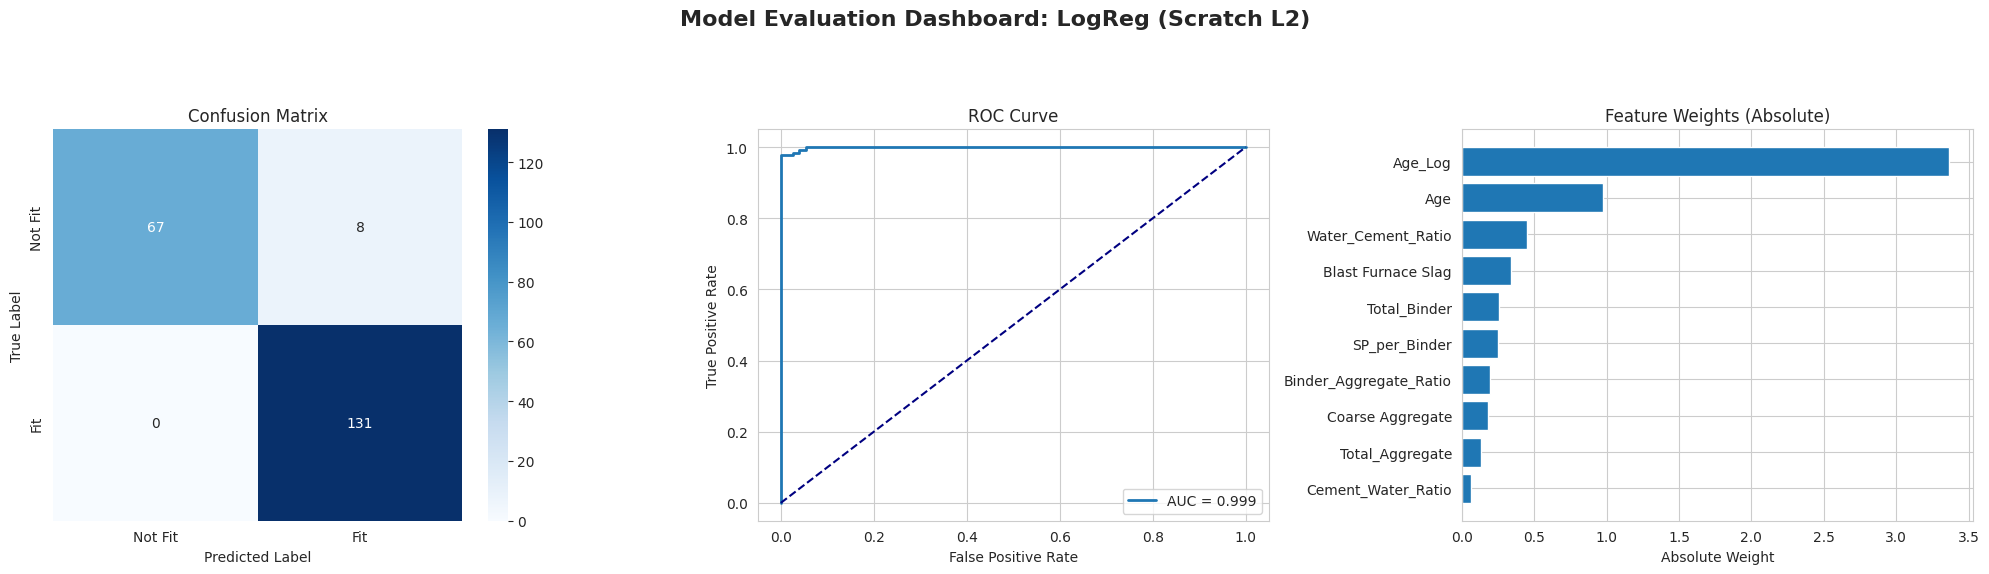


Evaluating Model: LogReg (Scratch L1)


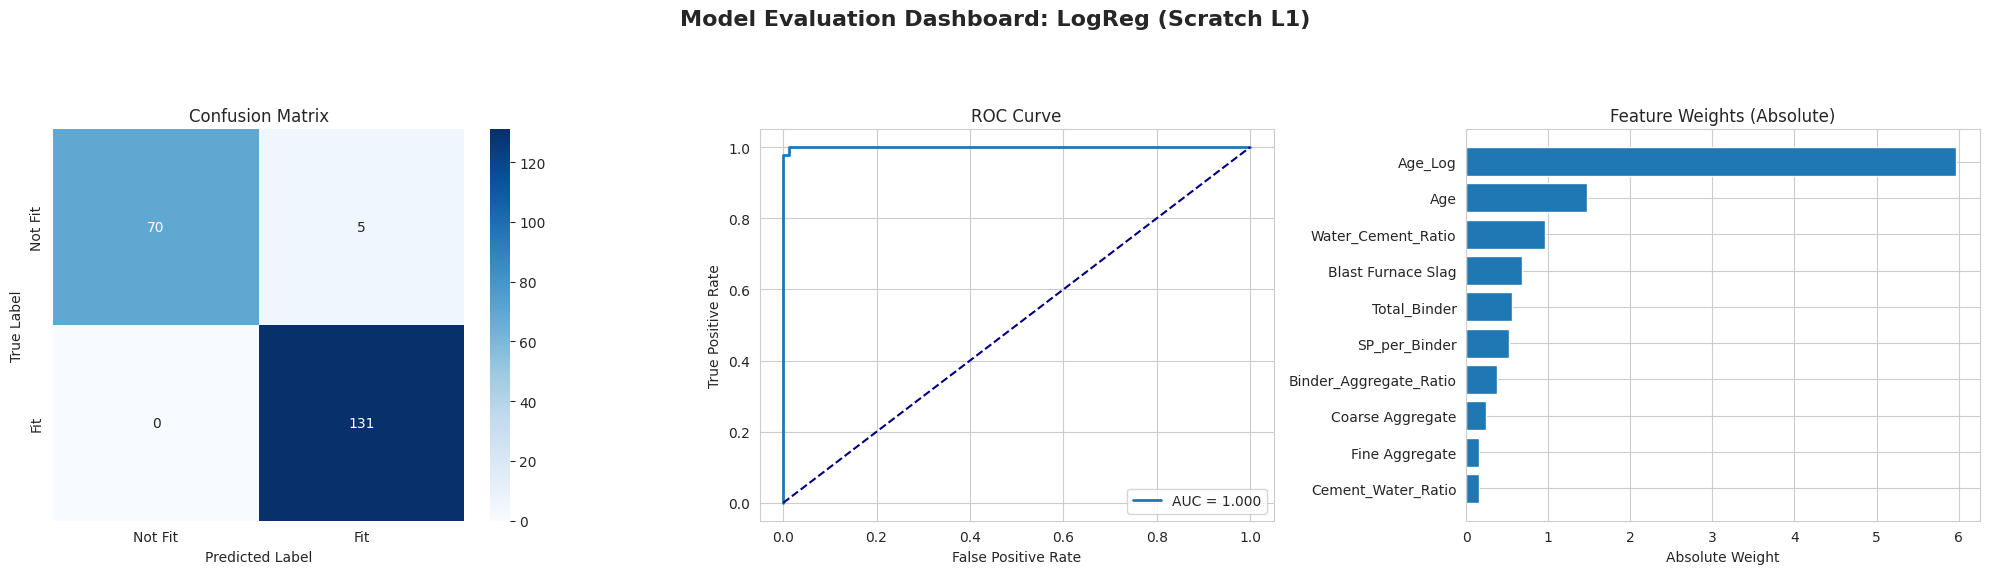


Evaluating Model: LogReg (Sklearn)


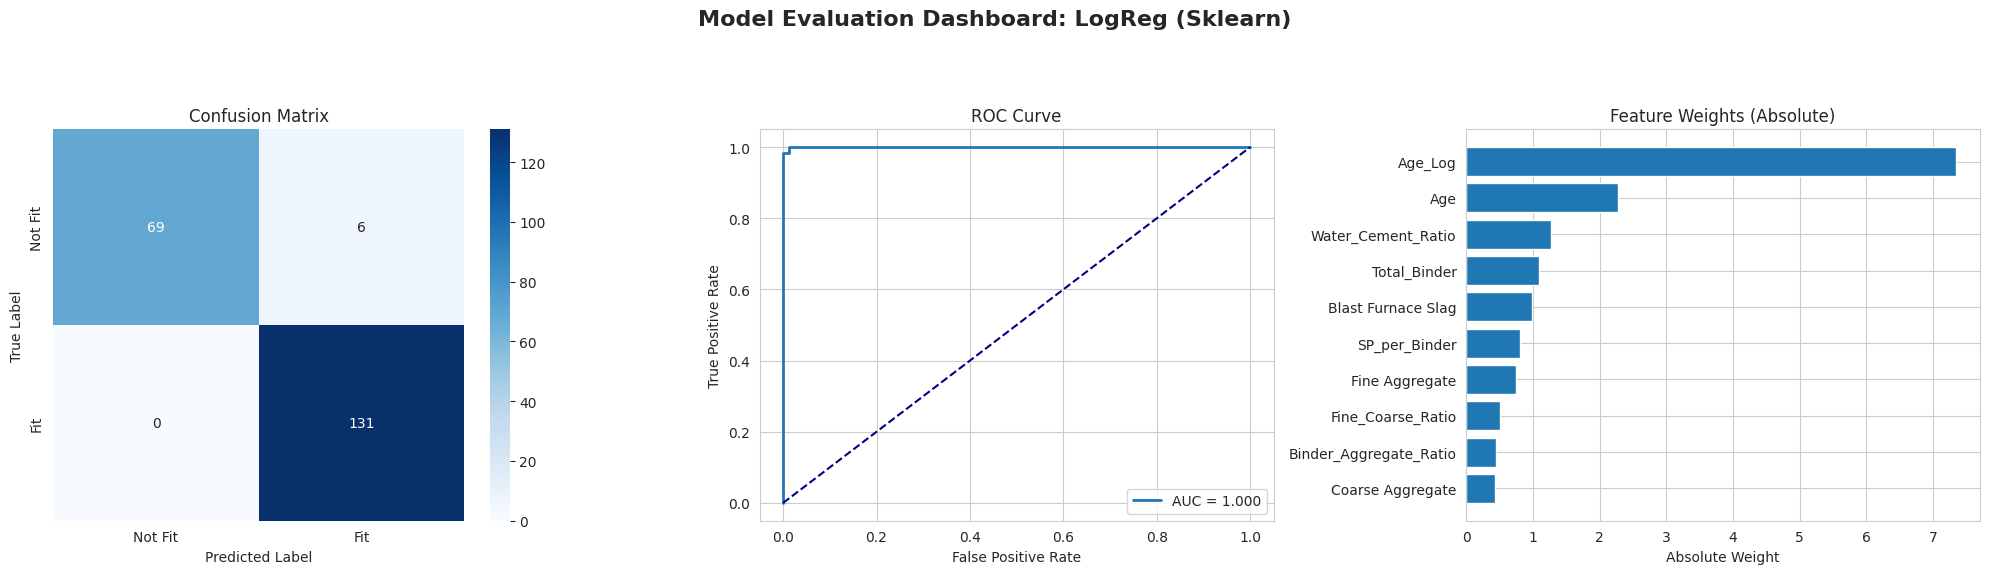


Evaluating Model: Random Forest


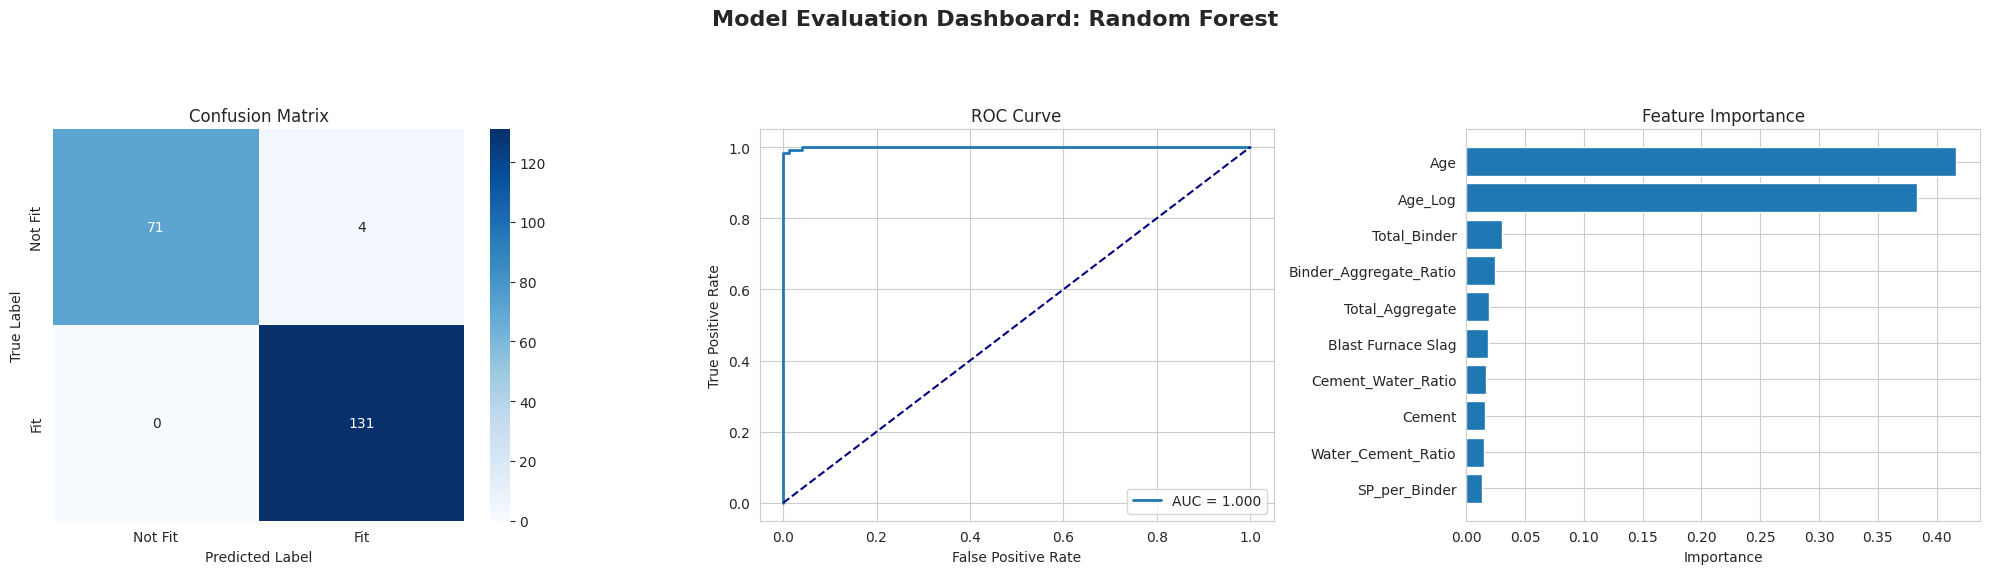


Evaluating Model: Gradient Boosting


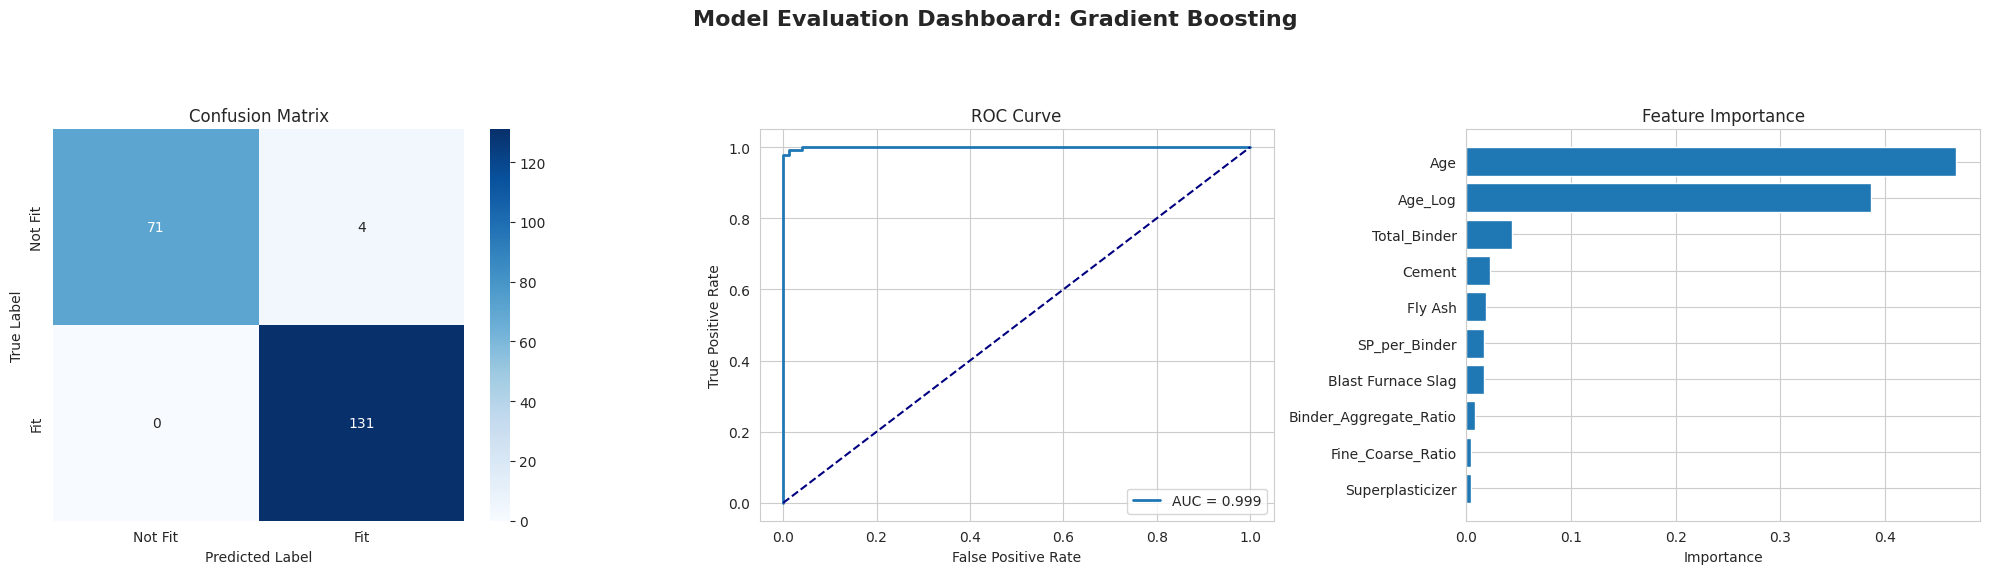


Evaluating Model: SVM


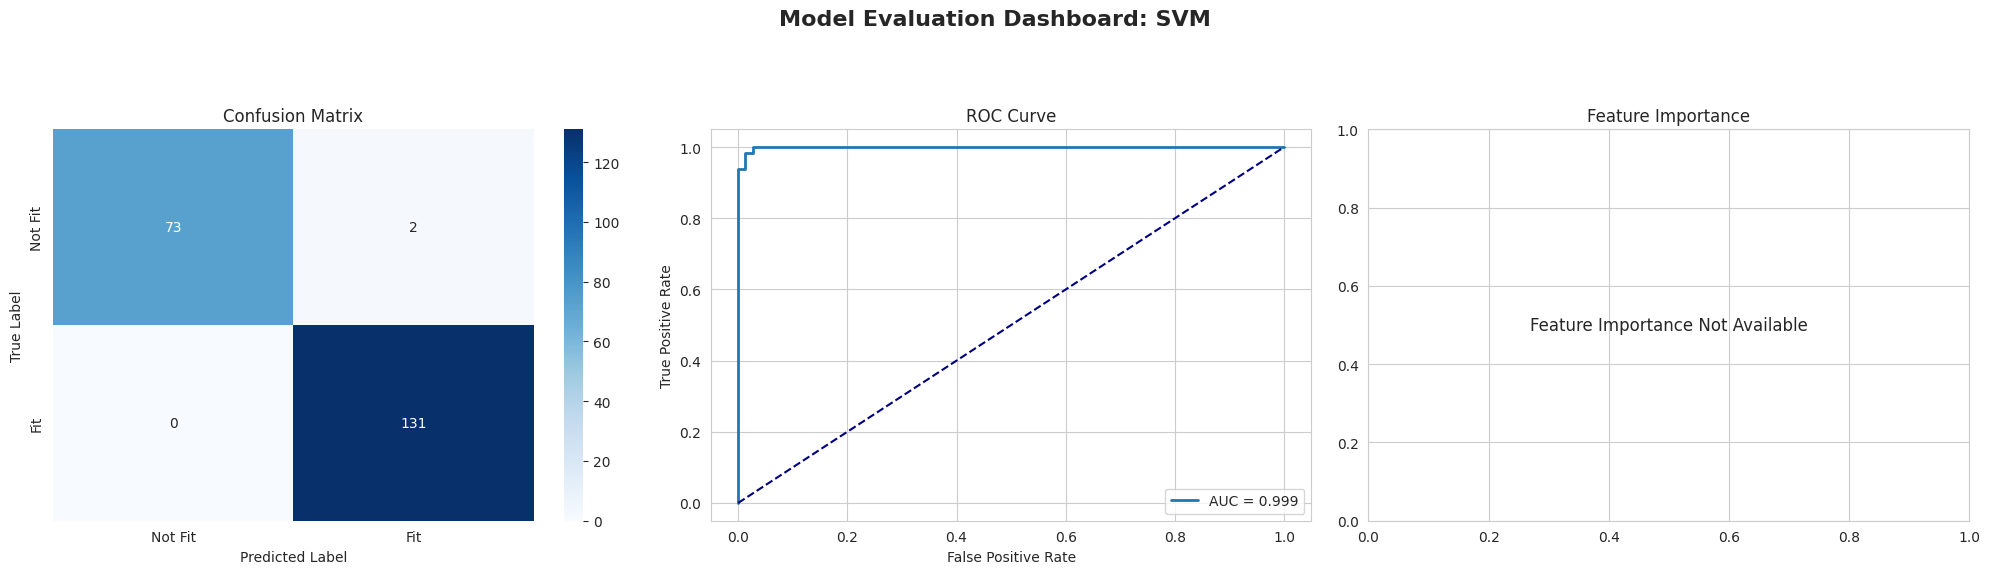


Evaluating Model: Decision Tree


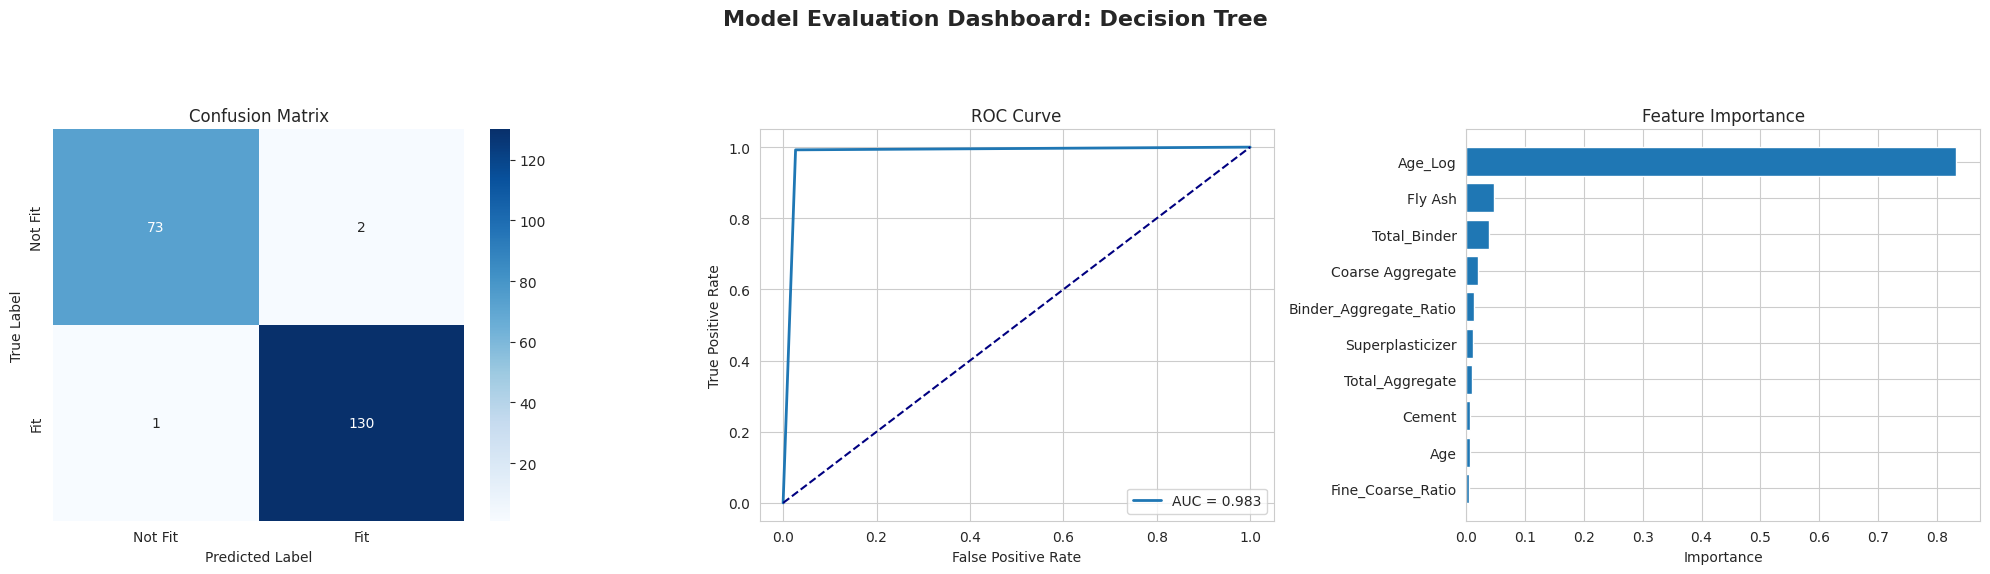


Evaluating Model: RF (Tuned)


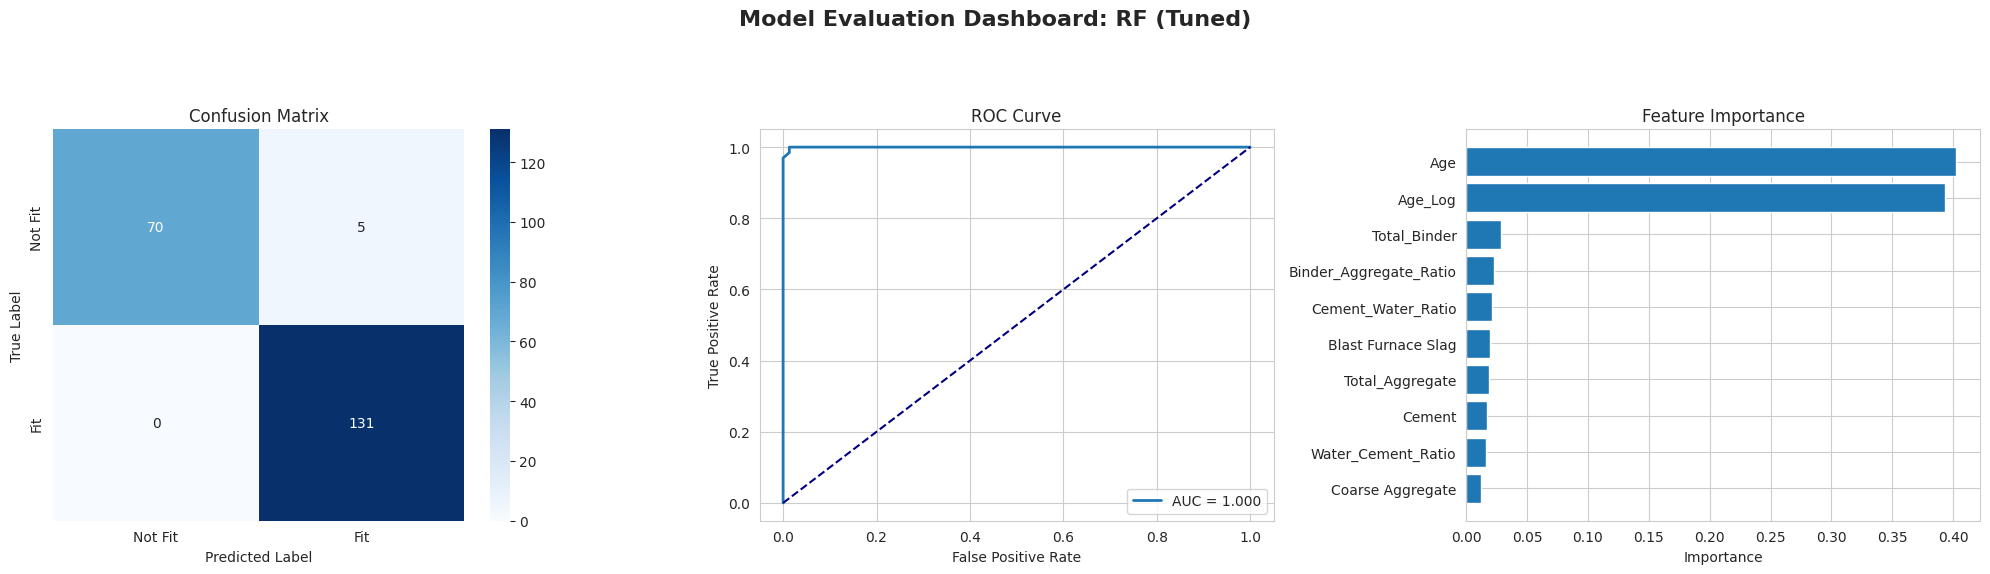


Evaluating Model: DT (Tuned)


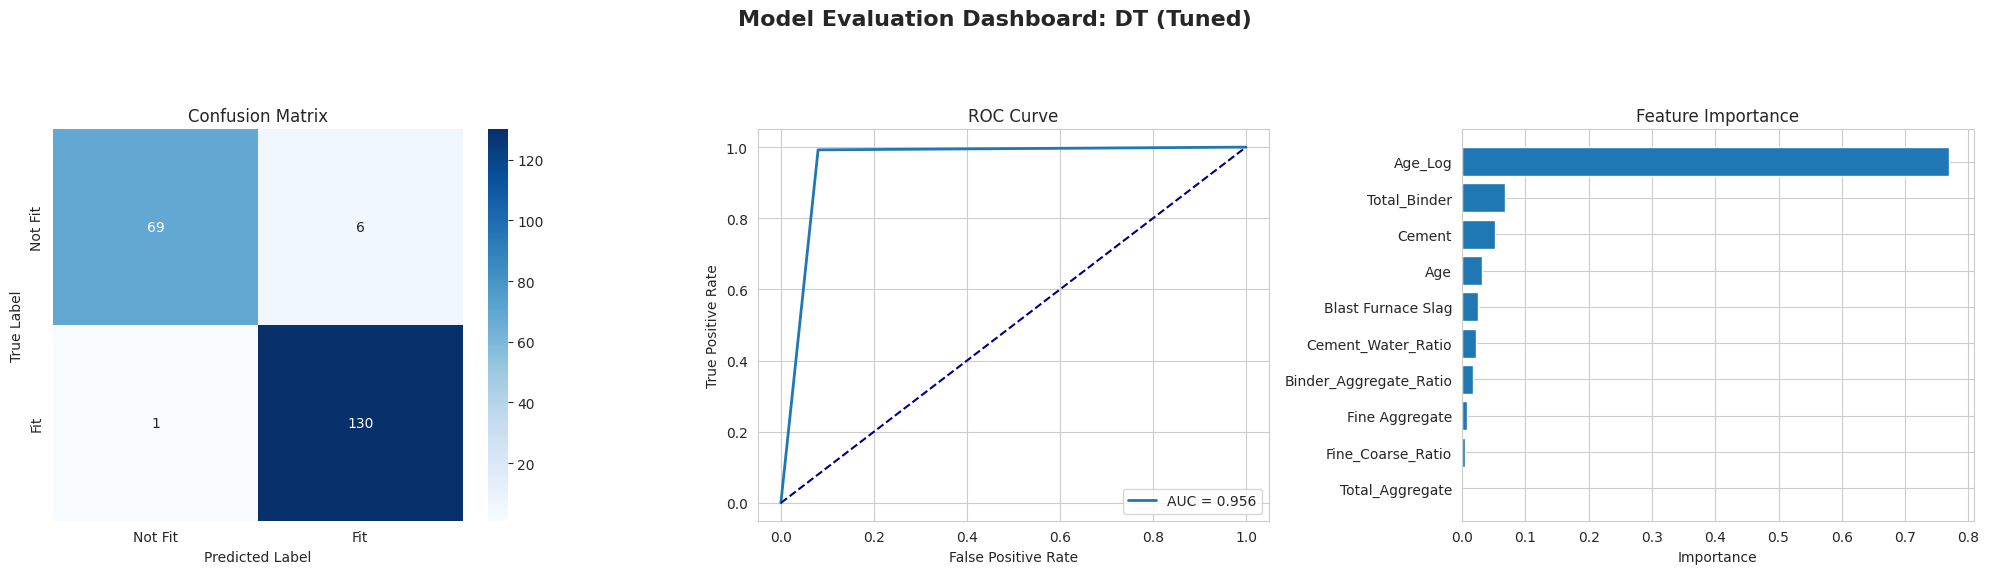


Evaluating Model: LogReg (Sklearn Tuned)


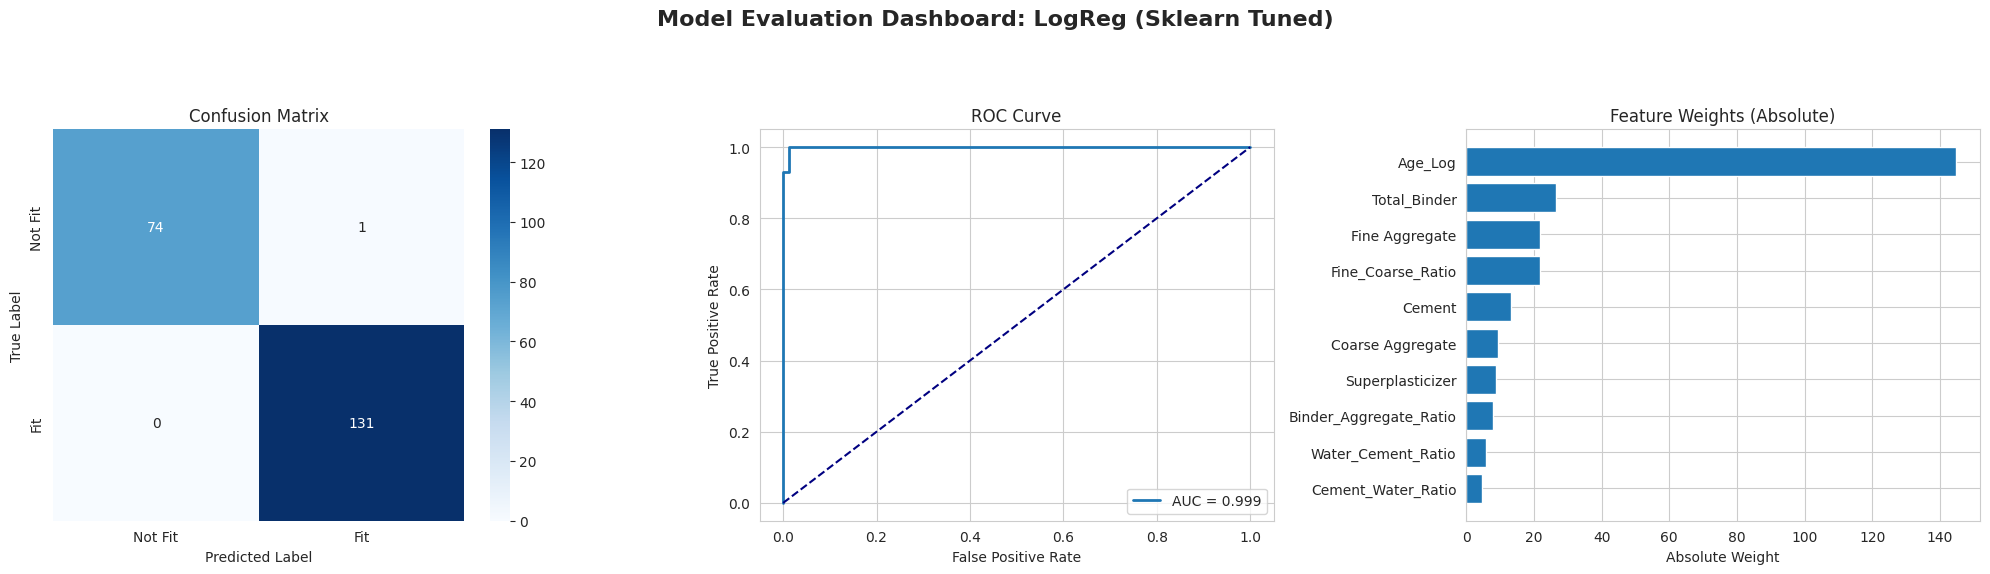


Evaluating Model: Gradient Boosting (Tuned)


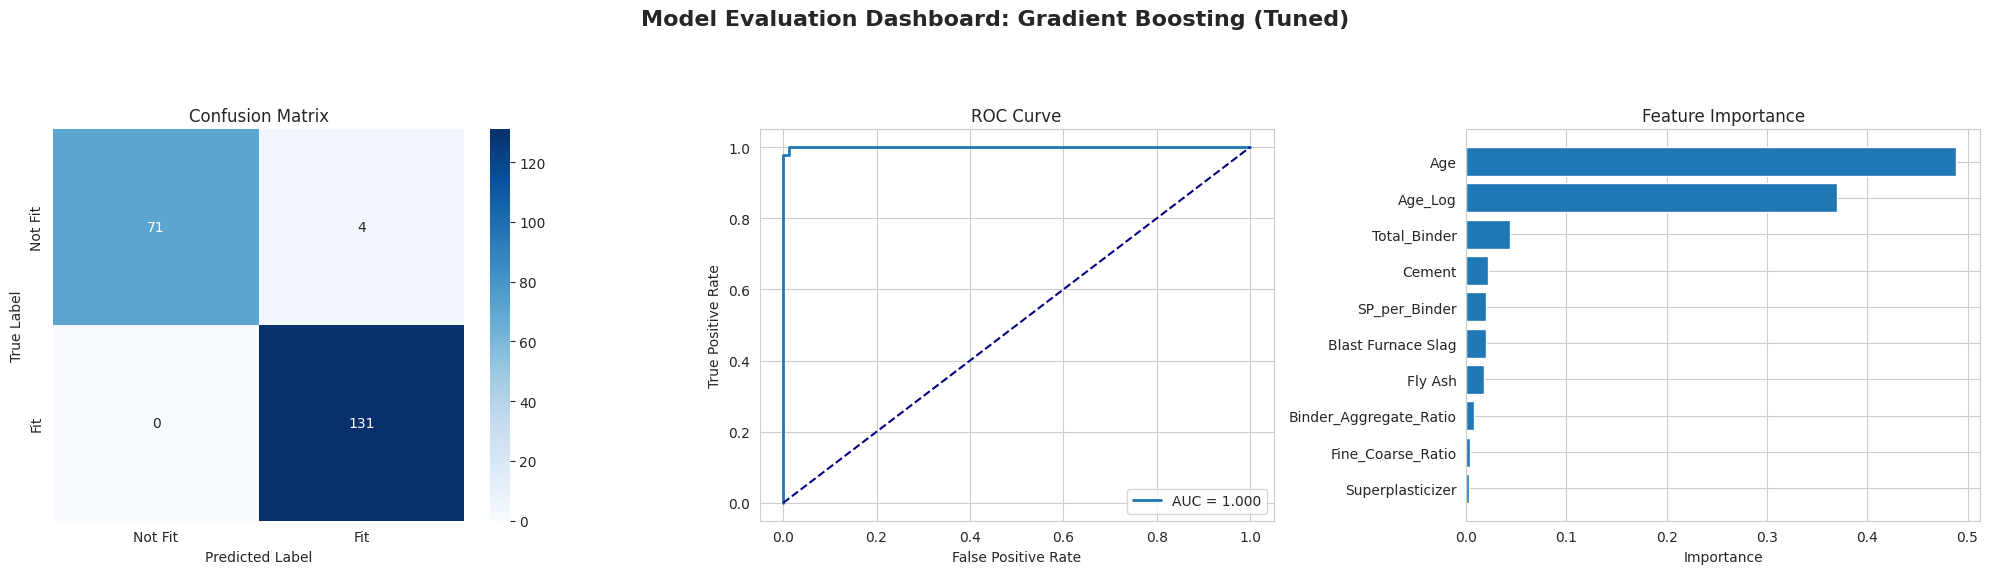


Evaluating Model: SVM (Tuned)


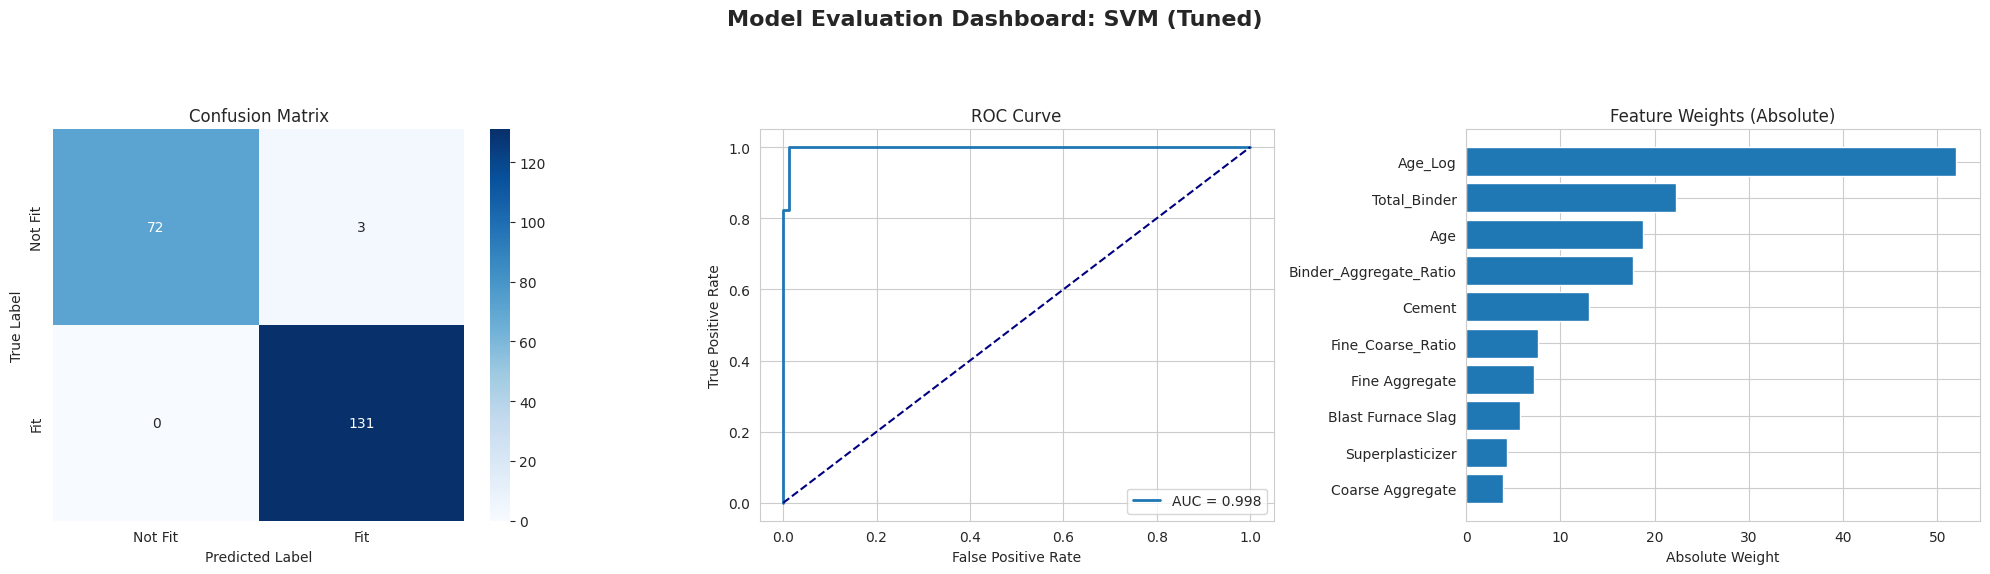


Best classification model by F1-score: LogReg (Sklearn Tuned)

Classification Report for Best Model:
              precision    recall  f1-score   support

     Not Fit       1.00      0.99      0.99        75
         Fit       0.99      1.00      1.00       131

    accuracy                           1.00       206
   macro avg       1.00      0.99      0.99       206
weighted avg       1.00      1.00      1.00       206



In [21]:
# Detailed Evaluation Dashboards (Classification)

for model_name, res in results_cls.items():
    print(f"\nEvaluating Model: {model_name}")

    plt.figure(figsize=(20, 6))
    plt.suptitle(f'Model Evaluation Dashboard: {model_name}', fontsize=16, fontweight='bold')

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_test_cls, res['y_pred'])
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Not Fit', 'Fit'],
        yticklabels=['Not Fit', 'Fit']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_test_cls, res['y_prob'])
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {res["AUC"]:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # Feature Importance / Coefficients
    plt.subplot(1, 3, 3)
    model_obj = res['model']

    if hasattr(model_obj, 'feature_importances_'):
        importances = model_obj.feature_importances_
        indices = np.argsort(importances)[-10:]
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features_list_cls[i] for i in indices])
        plt.title('Feature Importance')
        plt.xlabel('Importance')

    elif isinstance(model_obj, LogisticRegressionScratch) and hasattr(model_obj, 'weights'):
        coefs = model_obj.weights
        indices = np.argsort(np.abs(coefs))[-10:]
        plt.barh(range(len(indices)), np.abs(coefs)[indices], align='center')
        plt.yticks(range(len(indices)), [features_list_cls[i] for i in indices])
        plt.title('Feature Weights (Absolute)')
        plt.xlabel('Absolute Weight')

    elif hasattr(model_obj, 'coef_'):
        coefs = model_obj.coef_[0]
        indices = np.argsort(np.abs(coefs))[-10:]
        plt.barh(range(len(indices)), np.abs(coefs)[indices], align='center')
        plt.yticks(range(len(indices)), [features_list_cls[i] for i in indices])
        plt.title('Feature Weights (Absolute)')
        plt.xlabel('Absolute Weight')

    else:
        plt.text(
            0.5, 0.5, 'Feature Importance Not Available',
            horizontalalignment='center', verticalalignment='center',
            transform=plt.gca().transAxes, fontsize=12
        )
        plt.title('Feature Importance')

    plt.tight_layout(rect=[0, 0.03, 1, 0.9])
    plt.show()

best_model_name_cls = max(results_cls, key=lambda k: results_cls[k]['F1'])
print("\nBest classification model by F1-score:", best_model_name_cls)
print("\nClassification Report for Best Model:")
print(classification_report(
    y_test_cls,
    results_cls[best_model_name_cls]['y_pred'],
    target_names=['Not Fit', 'Fit']
))


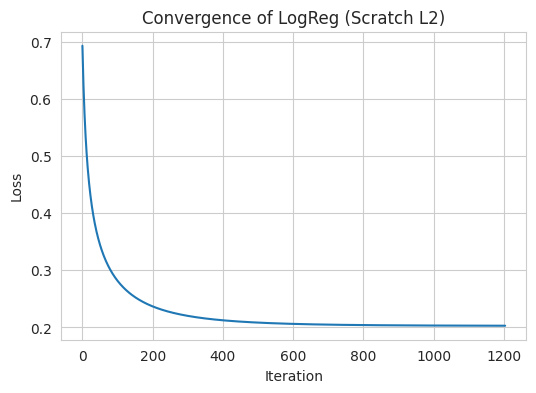

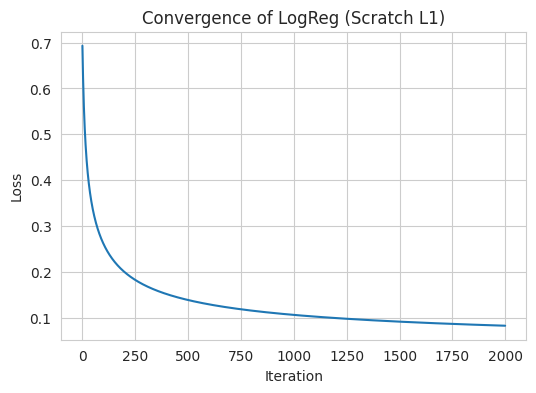

In [22]:
# Convergence Plots for Scratch Logistic Regression

for name in ['LogReg (Scratch L2)', 'LogReg (Scratch L1)']:
    model = results_cls[name]['model']
    plt.figure(figsize=(6, 4))
    plt.plot(model.cost_history)
    plt.title(f'Convergence of {name}')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


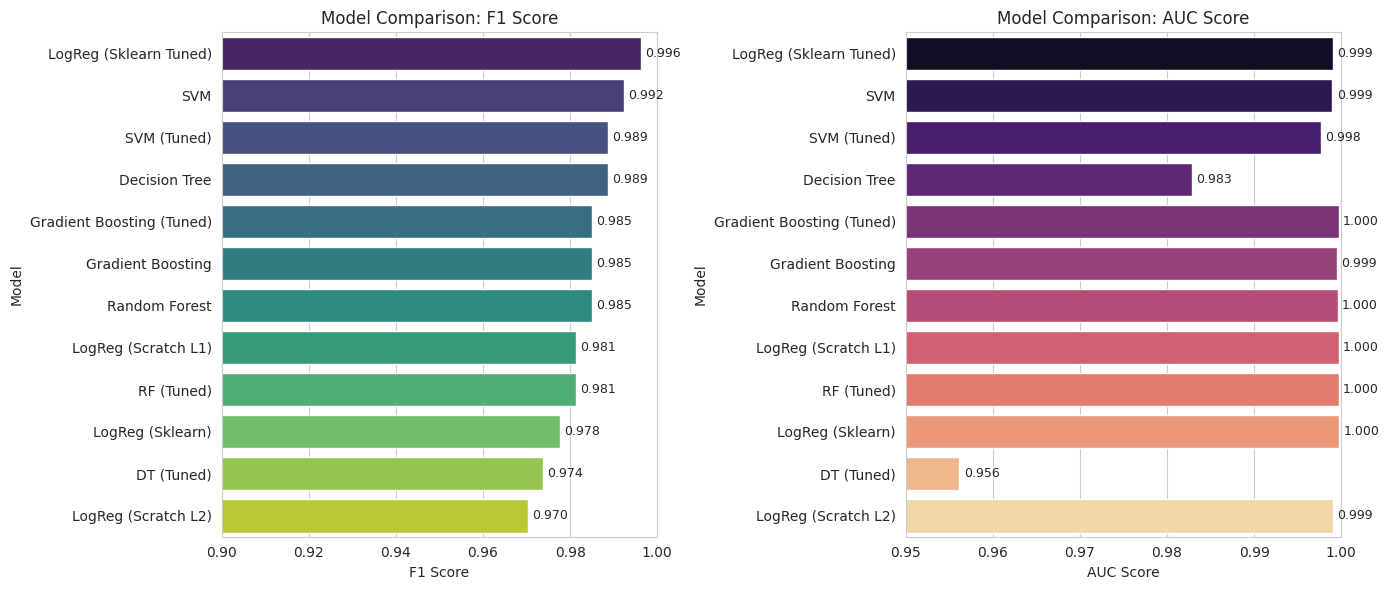


Model Performance Summary (sorted by F1 Score):


In [23]:
# Model Comparison Dashboard (Classification)

metrics_data_cls = []
for name, res in results_cls.items():
    metrics_data_cls.append({
        'Model': name,
        'Accuracy': res['Accuracy'],
        'Precision': res['Precision'],
        'Recall': res['Recall'],
        'F1 Score': res['F1'],
        'AUC Score': res['AUC']
    })

df_metrics_cls = pd.DataFrame(metrics_data_cls)
df_metrics_sorted_by_f1 = df_metrics_cls.sort_values(by='F1 Score', ascending=False)

plt.figure(figsize=(14, 6))

# F1 Score
plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    x='F1 Score',
    y='Model',
    data=df_metrics_sorted_by_f1,
    palette='viridis'
)
plt.title('Model Comparison: F1 Score')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0.9, 1.0)

for bar in ax1.patches:
    width = bar.get_width()
    y_plot = bar.get_y() + bar.get_height() / 2
    ax1.text(width + 0.001, y_plot, f"{width:.3f}", va='center', ha='left', fontsize=9)

# AUC Score
plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    x='AUC Score',
    y='Model',
    data=df_metrics_sorted_by_f1,
    palette='magma'
)
plt.title('Model Comparison: AUC Score')
plt.xlabel('AUC Score')
plt.ylabel('Model')
plt.xlim(0.95, 1.0)

for bar in ax2.patches:
    width = bar.get_width()
    y_plot = bar.get_y() + bar.get_height() / 2
    ax2.text(width + 0.0005, y_plot, f"{width:.3f}", va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

print("\nModel Performance Summary (sorted by F1 Score):")
display(df_metrics_sorted_by_f1.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}',
    'AUC Score': '{:.4f}'
}))

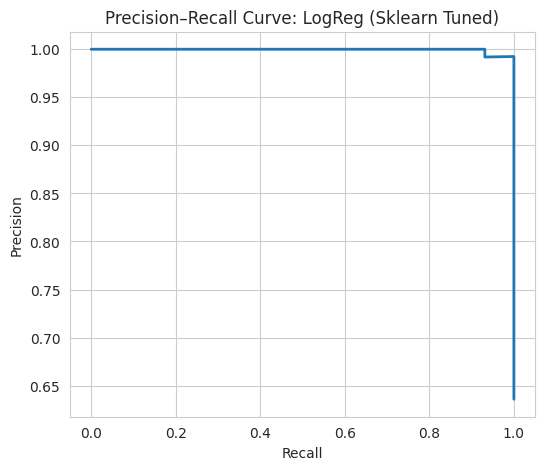

In [24]:
# Precision–Recall Curve for Best Classification Model

best_res_cls = results_cls[best_model_name_cls]
precision_vals, recall_vals, _ = precision_recall_curve(y_test_cls, best_res_cls['y_prob'])

plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve: {best_model_name_cls}')
plt.grid(True)
plt.show()

In [25]:
# DEPLOYMENT FUNCTION (CLASSIFICATION)

def assess_concrete_mix(cement, slag, ash, water, superplastic, coarse, fine, age):
    """
    Assess a concrete mix and predict if it is FIT for RCC based on the best trained
    classification model. Applies the same feature engineering + scaling as in the
    classification pipeline.
    """
    best_model_name = max(results_cls, key=lambda k: results_cls[k]['F1'])
    best_model = results_cls[best_model_name]['model']

    input_data = pd.DataFrame({
        'Cement': [cement],
        'Blast Furnace Slag': [slag],
        'Fly Ash': [ash],
        'Water': [water],
        'Superplasticizer': [superplastic],
        'Coarse Aggregate': [coarse],
        'Fine Aggregate': [fine],
        'Age': [age]
    })

    eps = 1e-6
    input_data['Cement_Water_Ratio'] = input_data['Cement'] / (input_data['Water'] + eps)
    input_data['Total_Binder'] = input_data['Cement'] + input_data['Blast Furnace Slag'] + input_data['Fly Ash']
    input_data['Water_Cement_Ratio'] = input_data['Water'] / (input_data['Cement'] + eps)
    input_data['Total_Aggregate'] = input_data['Coarse Aggregate'] + input_data['Fine Aggregate']
    input_data['Fine_Coarse_Ratio'] = input_data['Fine Aggregate'] / (input_data['Coarse Aggregate'] + eps)
    input_data['Age_Log'] = np.log(input_data['Age'] + 1)

    if 'Binder_Aggregate_Ratio' in features_list_cls:
        input_data['Binder_Aggregate_Ratio'] = input_data['Total_Binder'] / (input_data['Total_Aggregate'] + eps)
    if 'SP_per_Binder' in features_list_cls:
        input_data['SP_per_Binder'] = input_data['Superplasticizer'] / (input_data['Total_Binder'] + eps)

    input_model_features = input_data[features_list_cls]
    input_scaled = scaler_cls.transform(input_model_features)

    if hasattr(best_model, "predict_proba"):
        prob = best_model.predict_proba(input_scaled)[0, 1]
    else:
        scores = best_model.decision_function(input_scaled)
        prob = 1 / (1 + np.exp(-scores[0]))

    pred = int(prob >= 0.5)
    result = " FIT for RCC" if pred == 1 else " NOT FIT for RCC"

    print(f"\nMix Specs → Cement={cement}, Water={water}, Age={age}")
    print(f"Selected Model: {best_model_name}")
    print(f"Prediction: {result}  |  Confidence={prob:.3f}\n")
    return pred, prob

print("\n--- Deployment Test (Classification) ---")
assess_concrete_mix(350, 0, 0, 180, 0, 950, 800, 28)   # Expected: FIT
assess_concrete_mix(200, 0, 0, 200, 0, 950, 800, 7)    # Expected: NOT FIT



--- Deployment Test (Classification) ---

Mix Specs → Cement=350, Water=180, Age=28
Selected Model: LogReg (Sklearn Tuned)
Prediction:  FIT for RCC  |  Confidence=1.000


Mix Specs → Cement=200, Water=200, Age=7
Selected Model: LogReg (Sklearn Tuned)
Prediction:  NOT FIT for RCC  |  Confidence=0.000



(0, np.float64(7.331295589747148e-84))